# **Setup**


In [785]:
%pip install xgboost missingno pandas scikit-learn numpy seaborn matplotlib


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [786]:
import missingno as msno
import os
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from xgboost import XGBRegressor
import plotly.subplots as sp
import numpy as np

In [787]:
# Import Library


DATA_DIR = "data"
SUBMISSION_DIR = "submission"
TRAIN_PATH = os.path.join(DATA_DIR, "train.csv")
TEST_PATH = os.path.join(DATA_DIR, "test_case.csv")
SUBMISSION_PATH = os.path.join(DATA_DIR, "sample_submission.csv")
TARGET = "apparent_temperature (°C)"

"""
Change filename up to your preference
"""
SUBMISSION_NAME = f"submission_{datetime.now().day}-{datetime.now().month}-{datetime.now().year}-{datetime.now().hour}-{datetime.now().minute}.csv"
SUBMISSION_FILE = os.path.join(SUBMISSION_DIR, SUBMISSION_NAME)

In [788]:
pd.set_option("display.max_columns", None)

In [789]:
# Load Data

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
submission = pd.read_csv(SUBMISSION_PATH)

## **Exploratory Data Analysis (EDA)**


### **Data Structure**

To start things off, we'll do a preview of the overall data structure.

The data is of Solar Irradiance-esque dataset, which is usually used for weather-related uses and photovoltaics. Sure enough, our target is the `apparent_temperature (°C)` column.

Here, we see that there's an `id` column, which I'd imagine won't be significant at all to the predictive power of the resulting model. I.e., there really wouldn't be any correlation I feel like. There's also the `time` column, which is an `object` dtype.

Interestingly, there's also a `city` column, which is a categorical `object` dtype column, so we'll do some preliminary preprocessing to address that as well down below so that we can check it out as part of the EDA as well. This is interesting, because usually when we're working with Solar Irradiance, we'd probably want to tighten the scope down to a specific city, but here it seems like we're handling multiple cities in the same dataset.


In [790]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238644 entries, 0 to 238643
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   time                                238644 non-null  object 
 1   temperature_2m (°C)                 238525 non-null  float64
 2   relativehumidity_2m (%)             238525 non-null  float64
 3   dewpoint_2m (°C)                    238525 non-null  float64
 4   apparent_temperature (°C)           238525 non-null  float64
 5   pressure_msl (hPa)                  238525 non-null  float64
 6   surface_pressure (hPa)              238525 non-null  float64
 7   snowfall (cm)                       238525 non-null  float64
 8   cloudcover (%)                      238525 non-null  float64
 9   cloudcover_low (%)                  238525 non-null  float64
 10  cloudcover_mid (%)                  238525 non-null  float64
 11  cloudcover_high (%)       

In [791]:
train.sample(10)

,time,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),pressure_msl (hPa),surface_pressure (hPa),snowfall (cm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),windspeed_10m (km/h),windspeed_100m (km/h),winddirection_10m (°),winddirection_100m (°),windgusts_10m (km/h),et0_fao_evapotranspiration (mm),vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),city,id
36773,2018-09-14T22:00,25.4,88.0,23.4,29.2,1011.2,1010.7,0.0,42.0,12.0,2.0,100.0,0.0,0.0,0.0,0.0,13.6,22.3,192.0,190.0,24.8,0.01,0.38,25.5,26.9,26.7,26.8,0.296,0.316,0.305,0.359,p,133006
119537,2020-09-12T21:00,23.7,96.0,22.9,30.3,1013.1,1014.8,0.0,93.0,3.0,100.0,100.0,0.0,0.0,0.0,0.0,6.6,9.8,279.0,298.0,12.6,0.00,0.13,24.9,26.1,26.7,27.0,0.453,0.449,0.443,0.431,lh,182325
111309,2018-03-01T22:00,24.9,93.0,23.7,32.6,1010.8,1012.5,0.0,50.0,1.0,32.0,99.0,0.0,0.0,0.0,0.0,6.0,8.8,245.0,258.0,10.1,0.00,0.22,25.9,26.9,26.3,26.1,0.410,0.381,0.358,0.426,lh,160102
51700,2018-10-22T03:00,23.9,93.0,22.7,29.1,1011.8,1013.5,0.0,41.0,11.0,7.0,89.0,0.0,0.0,0.0,0.0,6.0,10.0,155.0,150.0,11.5,0.00,0.20,24.6,26.0,26.2,26.7,0.424,0.442,0.454,0.449,lh,165723
187412,2021-01-22T02:00,25.3,98.0,25.0,31.6,1010.0,992.6,0.0,100.0,52.0,90.0,99.0,0.0,0.0,0.0,0.0,1.1,4.3,288.0,318.0,6.8,0.00,0.06,21.8,22.8,23.3,23.9,0.445,0.444,0.403,0.451,le,121874
232225,2019-02-20T23:00,9.9,97.0,9.4,8.7,1020.4,743.9,0.0,62.0,21.0,22.0,98.0,0.0,0.0,0.0,0.0,0.7,3.6,180.0,174.0,13.7,0.00,0.04,13.3,15.7,16.5,16.7,0.309,0.319,0.358,0.349,t,232703
138620,2021-04-14T03:00,24.1,94.0,23.1,31.4,1011.8,988.5,0.0,6.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,3.8,7.2,163.0,162.0,11.5,0.00,0.18,24.1,25.8,26.3,26.1,0.279,0.277,0.288,0.316,si,60411
163712,2018-02-09T19:00,25.9,87.0,23.6,31.4,1010.0,1009.5,0.0,56.0,5.0,41.0,88.0,0.0,0.0,0.0,0.0,2.5,3.1,270.0,234.0,12.2,0.00,0.42,27.1,27.1,27.1,27.2,0.399,0.402,0.397,0.397,p,127795
18824,2019-03-17T00:00,25.3,92.0,23.8,31.0,1010.4,1012.7,0.0,78.0,0.0,82.0,95.0,0.0,0.0,0.0,0.0,5.9,8.2,256.0,255.0,10.4,0.00,0.27,26.6,28.4,28.6,28.9,0.321,0.335,0.275,0.328,su,10560
209311,2018-04-28T04:00,25.6,96.0,25.0,30.7,1012.4,995.0,0.0,72.0,4.0,68.0,91.0,0.0,0.0,0.0,0.0,4.1,6.9,135.0,129.0,7.6,0.00,0.12,22.0,23.7,24.0,24.0,0.432,0.429,0.439,0.452,le,97876


In [792]:
train.describe()

,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),pressure_msl (hPa),surface_pressure (hPa),snowfall (cm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),windspeed_10m (km/h),windspeed_100m (km/h),winddirection_10m (°),winddirection_100m (°),windgusts_10m (km/h),et0_fao_evapotranspiration (mm),vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),id
count,238525.000000,238525.000000,238525.000000,238525.000000,238525.000000,238525.000000,238525.0,238525.000000,238525.000000,238525.000000,238525.000000,238525.000000,238525.000000,238525.000000,238532.000000,238525.000000,238525.000000,238193.000000,238384.000000,238525.000000,238525.000000,238525.000000,238525.000000,238525.000000,238525.000000,238525.000000,238525.000000,238525.000000,238525.000000,238525.000000,238644.000000
mean,24.988020,85.377025,22.162759,30.138572,1011.338306,966.926108,0.0,55.046938,24.106253,27.528812,68.198017,217.018107,144.744870,72.273238,202.861171,6.224378,8.788467,174.976775,173.566787,17.051732,0.160362,0.535525,25.257991,25.165960,25.141728,25.130634,0.294202,0.292757,0.290673,0.325280,119321.500000
std,4.670449,11.328758,3.840004,6.488240,2.672479,72.632241,0.0,29.215363,25.998342,28.259006,37.069607,293.243855,224.947746,94.485913,276.614083,4.151240,5.439981,88.625904,90.290490,7.761572,0.212483,0.517040,4.389839,3.746558,3.651253,3.609656,0.133169,0.133805,0.129542,0.115053,68890.733158
min,7.800000,21.000000,6.000000,6.200000,1002.700000,738.200000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.400000,0.000000,0.000000,10.900000,13.100000,14.900000,15.400000,0.033000,0.034000,0.035000,0.073000,0.000000
25%,24.100000,80.000000,21.200000,29.000000,1009.500000,984.800000,0.0,32.000000,5.000000,5.000000,37.000000,0.000000,0.000000,0.000000,0.000000,3.200000,4.700000,108.000000,106.000000,11.200000,0.000000,0.190000,22.900000,23.900000,24.100000,24.100000,0.184000,0.179000,0.157000,0.250000,59660.750000
50%,26.100000,88.000000,23.700000,31.900000,1011.100000,992.200000,0.0,52.000000,15.000000,18.000000,89.000000,10.000000,1.000000,8.000000,0.000000,5.200000,7.600000,180.000000,173.000000,15.800000,0.030000,0.390000,26.000000,26.300000,26.400000,26.400000,0.340000,0.334000,0.330000,0.371000,119321.500000
75%,27.800000,93.000000,24.600000,34.100000,1012.800000,1010.500000,0.0,80.000000,32.000000,40.000000,98.000000,423.000000,239.000000,132.000000,412.300000,8.400000,12.000000,236.000000,240.000000,22.000000,0.300000,0.730000,27.800000,27.400000,27.200000,27.200000,0.403000,0.402000,0.397000,0.414000,178982.250000
max,36.900000,100.000000,29.600000,46.200000,1022.600000,1018.800000,0.0,100.000000,100.000000,100.000000,100.000000,1078.000000,966.000000,476.000000,998.100000,33.100000,42.500000,360.000000,360.000000,67.300000,1.010000,4.670000,46.900000,35.100000,32.700000,31.600000,0.462000,0.462000,0.462000,0.461000,238643.000000


### **Preliminary Preprocessing**

Here, I did some preliminary preprocessing to allow for further EDA.

On the `city` column, I used a LabelEncoder because it's a categorical feature. Now, an OHE (One-Hot Encoding) would've worked fine as well here, _theoretically_. However, my personal anecdotal testing has concluded on this being a better-performing encoding for it, so, I just, chose it. :p Though this is likely due to the transforms I did down in the preprocessing steps later on.

I also dropped the `time` and `id` features here. For `id`, the rationale was explained above. Whilst for `time` I'm rationalizing it based on the fact that we're handling multiple cities, and so the `time` factor might not be so significant as the `city` could already address the local domain knowledge (i.e., whether it's usually hot or not for certain times could be represented by the general region which the city represents).


In [793]:
le = LabelEncoder()
train["city"] = le.fit_transform(train["city"]).astype(np.int64)

In [794]:
train.drop(["id", "time"], axis=1, inplace=True)

### **Correlation Matrix**

First, we do a correlation matrix. Here, I used a spearman rank coefficient because it's able to handle non-linear relationships. Solar irradiance data, being a cyclostationary, usually seasonal (depending on stationarity test results, I don't do it here tho for brevity lmao), time-series data, will model a non-linear relationship, so the use of this coefficient tracks with the domain knowledge.

Anyway, the use of this matrix here is to tackle out insignificant relationships in the data. I.e., correlation does not equal causation, however if the data does not represent the causative relationship in a great enough effect, we might as well assume no predictive power can be drawn from it as there's not enough data to model that relationship.

One relationship that'd be very important _theoretically_ is snowfall and the apparent temperature, as, with snowfall, the temperature will, of course, drop. However, as seen in the data, the snowfall practically has no correlative power to the entire dataset. This is because the snowfall feature has no unique values other than 0 (see the univariate analysis).

The rest seems to track fine with the usual factors relating to Solar Irradiance and temperature readings, i.e., here's a brief explainer on how irradiance measures work (on photovoltaics, at least, since I'm a bit more familiar with those, and PVs get affected by temps as well):

- GHI (Global Horizontal Irradiance): The total amount of solar radiation received by a horizontal surface, including both direct and diffuse sunlight.
- DNI (Direct Normal Irradiance): The amount of solar radiation received directly from the sun on a surface perpendicular to the sun's rays.
- DHI (Diffuse Horizontal Irradiance): The amount of radiation received from the sky (excluding direct sunlight) on a horizontal surface.

GHI reflects both the DHI and DNI, with the following relationship:

$$\text{GHI} = \text{DNI} \times \cos(\theta) + \text{DHI}$$

where $\theta$ is the solar zenith angle (angle of incidence of the sun's beam).

Now, the data has no GHI, which is kinda weird, but we can work with that, simply put: GHI is the mix of the ambient/diffused radiation and the direct irradiance. Now, usually irradiance measures don't have a... "direct radiation" measure, so what I'm thinking is it's probably just, the GHI, renamed weirdly, because the GHI is basically a "harmonic" measure that reflects both DNI and DHI, and in the data it seems to have taken on that middle ground between the two.


In [795]:
import pandas as pd
import plotly.express as px

correlation_matrix = train.select_dtypes(exclude=["object"]).corr("spearman")


def truncate_name(name, max_length=5):
    return name[:max_length] + "..." if len(name) > max_length else name


truncated_columns = [truncate_name(col) for col in correlation_matrix.columns]

fig = px.imshow(
    correlation_matrix,
    x=correlation_matrix.columns,
    y=correlation_matrix.columns,
    color_continuous_scale="plotly3",
    title="Correlation Matrix",
    labels=dict(color="Correlation"),
    text_auto=".2f",
)

fig.update_xaxes(
    ticktext=truncated_columns, tickvals=list(range(len(truncated_columns)))
)
fig.update_yaxes(
    ticktext=truncated_columns, tickvals=list(range(len(truncated_columns)))
)

fig.update_layout(
    title_x=0.5,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    yaxis_autorange="reversed",
)

fig.show()

### **Univariate Analysis**


#### **Skew Analysis**

To analyze the skew in the data, I used a histogram and a box-plot. Some notable observations:

1. Most of the data seems to exhibit a skew with pretty heavy tails (skew > 1 or -1 > skew for 16 of the features) and we'll have to address this in the preprocessing steps. This is due to the fact that predictive models rely on the normality assumption of natural phenomenas, where any class of a phenomena should have some probability of occurrence in the dataset, as such, if there's a heavy tail in the dataset, the predictive power of the model will decrease as the proportionality of the tail classes are then accumulatively overrepresented (i.e., the tail will get an almost equal priority to the classes within the larger mass of the set.)
2. `snowfall (cm)` only has one value, `0.0`, which means that it practically has no predictive power on the dataset, because _all_ the data has the same class for this feature, we'll drop this.
3. `city` exhibits some class imbalance for the 6th class, we'll have to also address this, because if we don't the predictive power of the model on said class will be significantly lower compared to the rest of the classes.

The handling of these will be addressed in the preprocessing steps later.


temperature_2m (°C)
Skew : -1.25


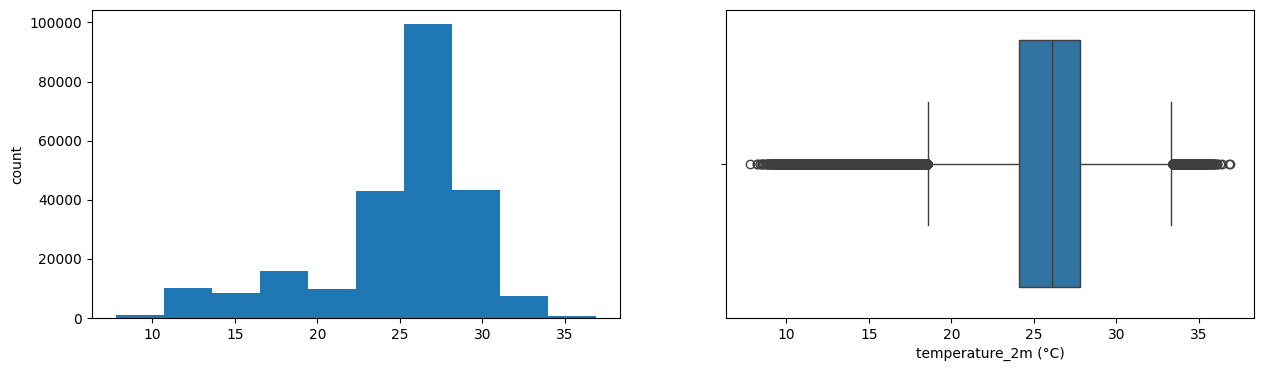

relativehumidity_2m (%)
Skew : -1.45


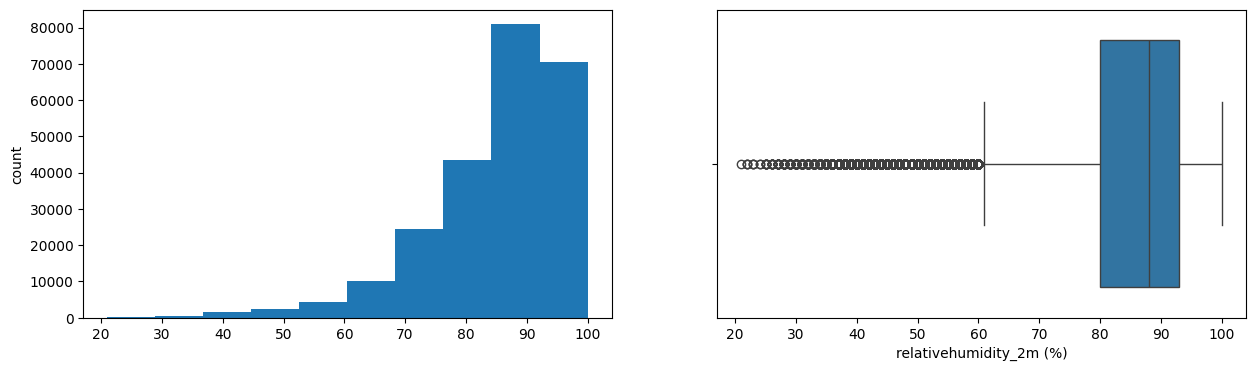

dewpoint_2m (°C)
Skew : -1.48


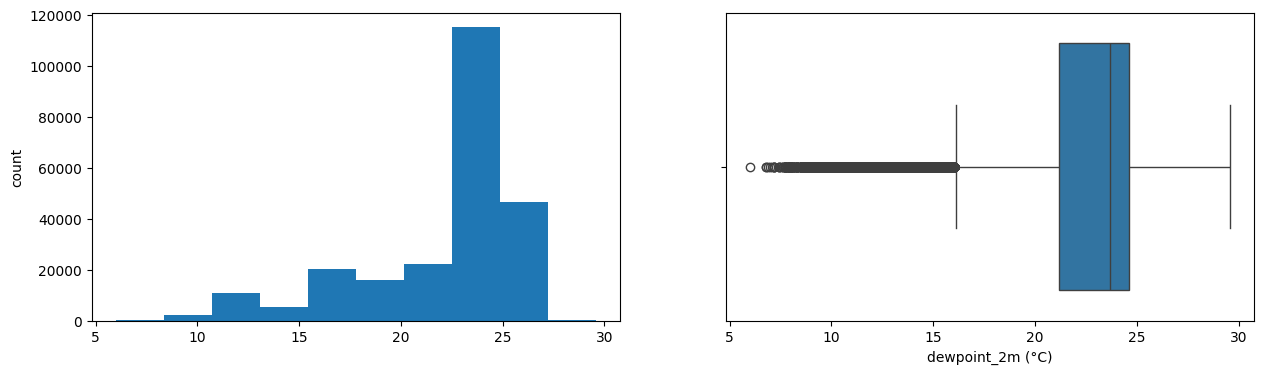

apparent_temperature (°C)
Skew : -1.29


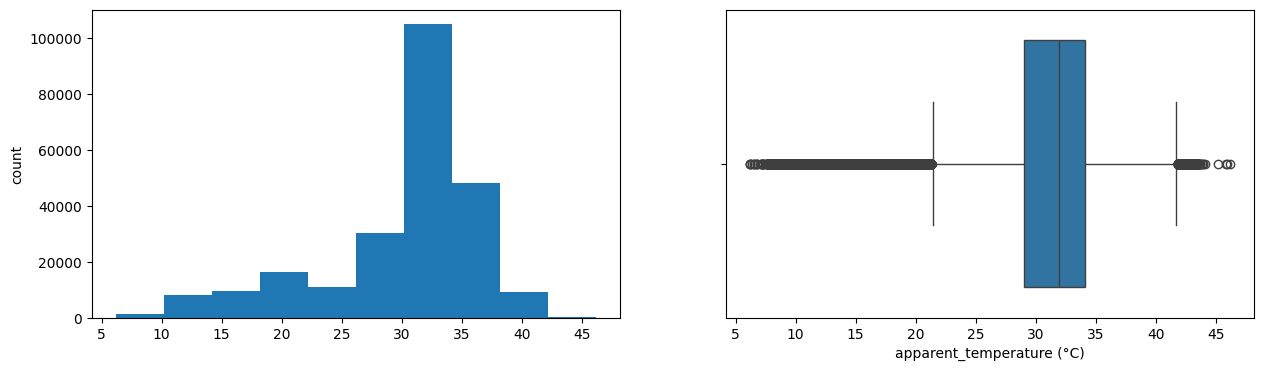

pressure_msl (hPa)
Skew : 0.6


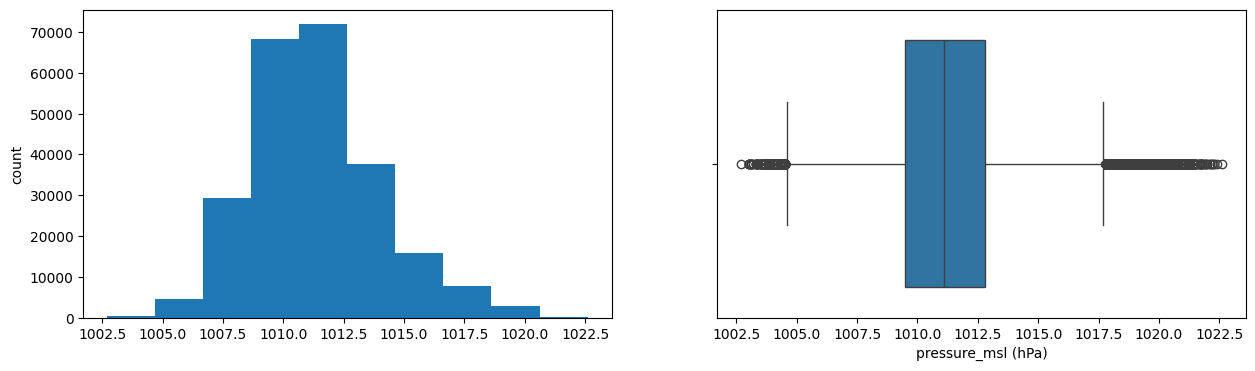

surface_pressure (hPa)
Skew : -2.03


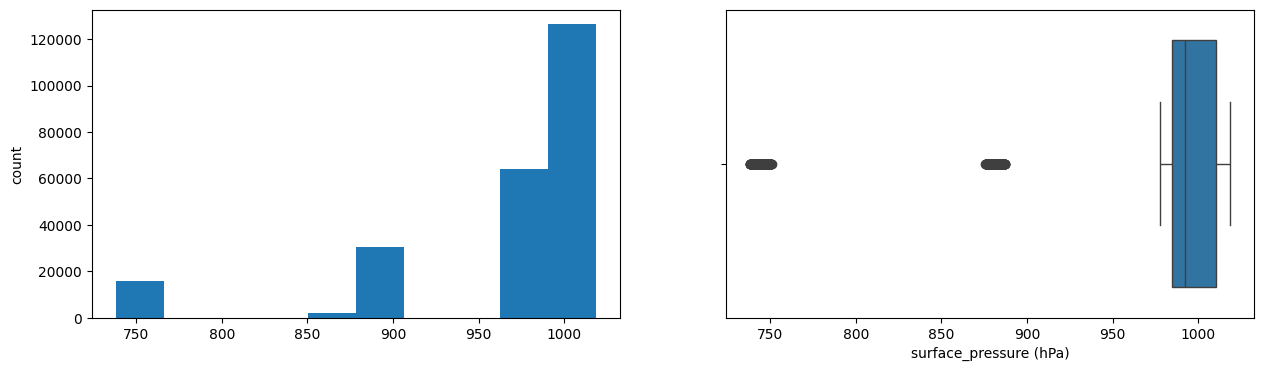

snowfall (cm)
Skew : 0.0


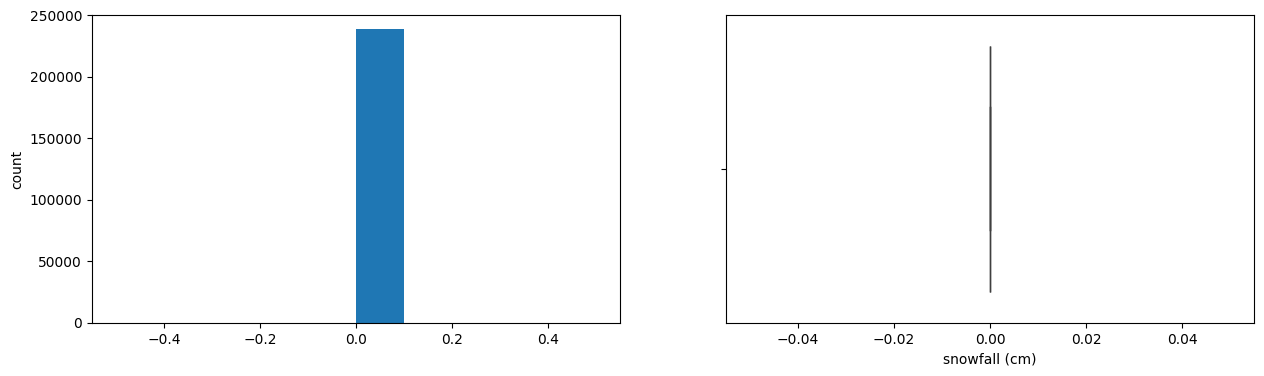

cloudcover (%)
Skew : 0.1


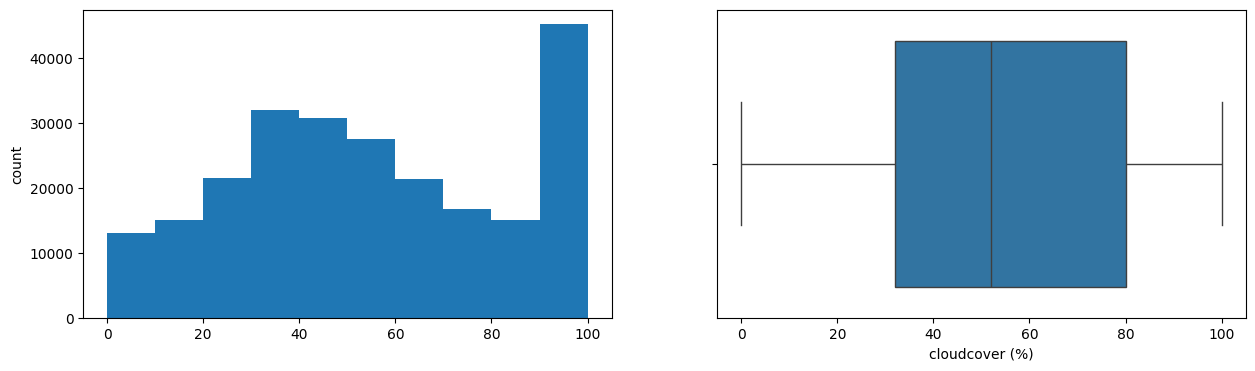

cloudcover_low (%)
Skew : 1.4


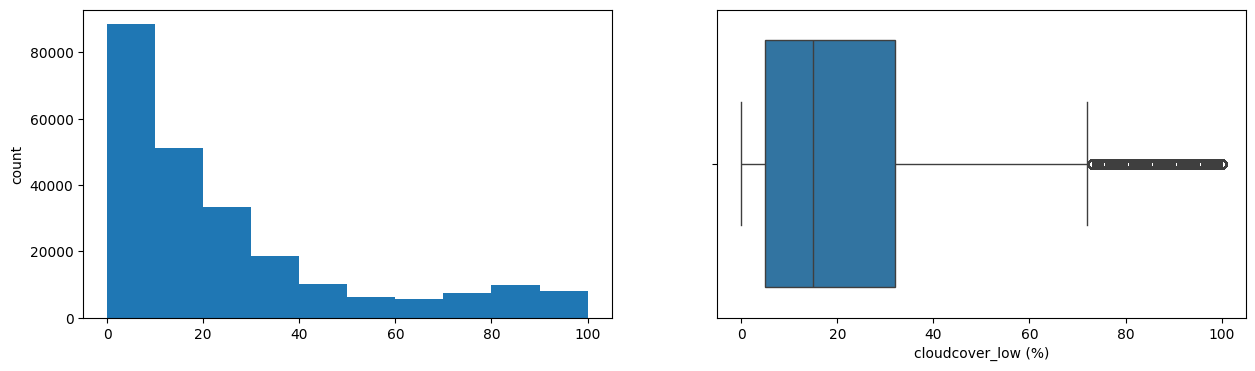

cloudcover_mid (%)
Skew : 1.16


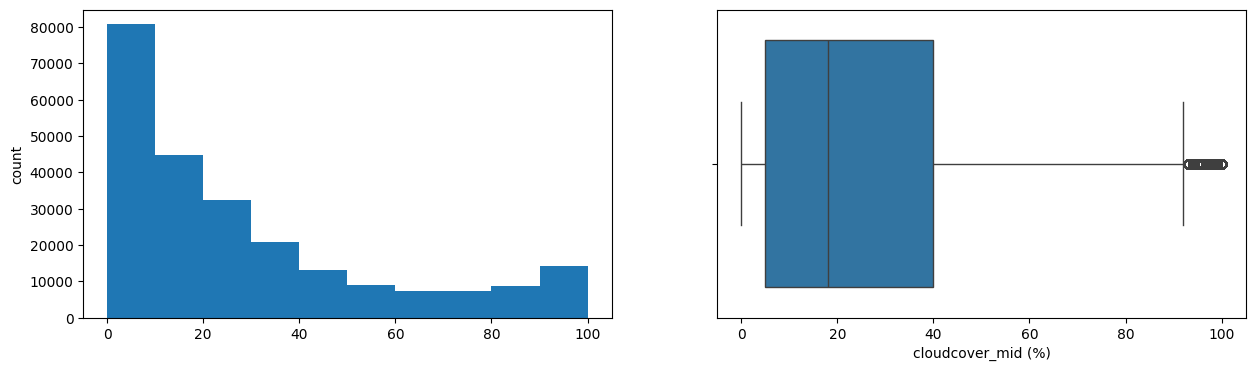

cloudcover_high (%)
Skew : -0.85


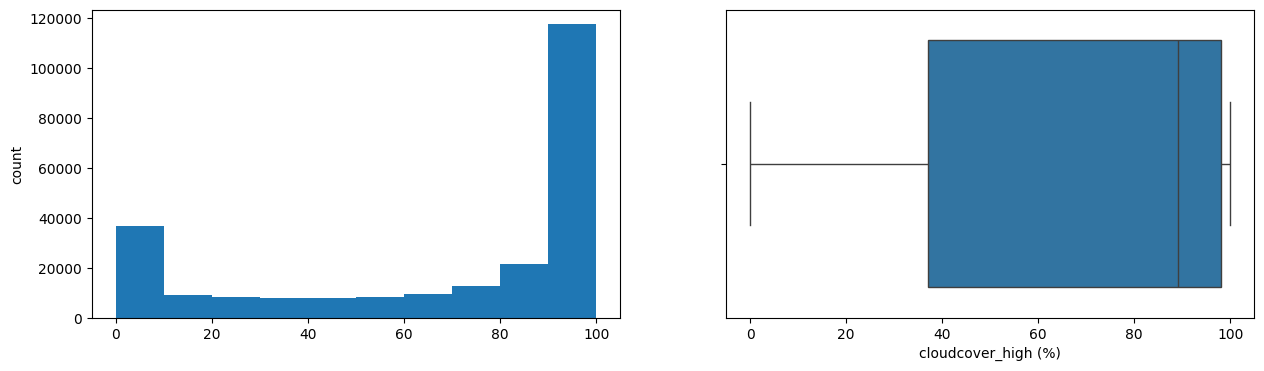

shortwave_radiation (W/m²)
Skew : 1.06


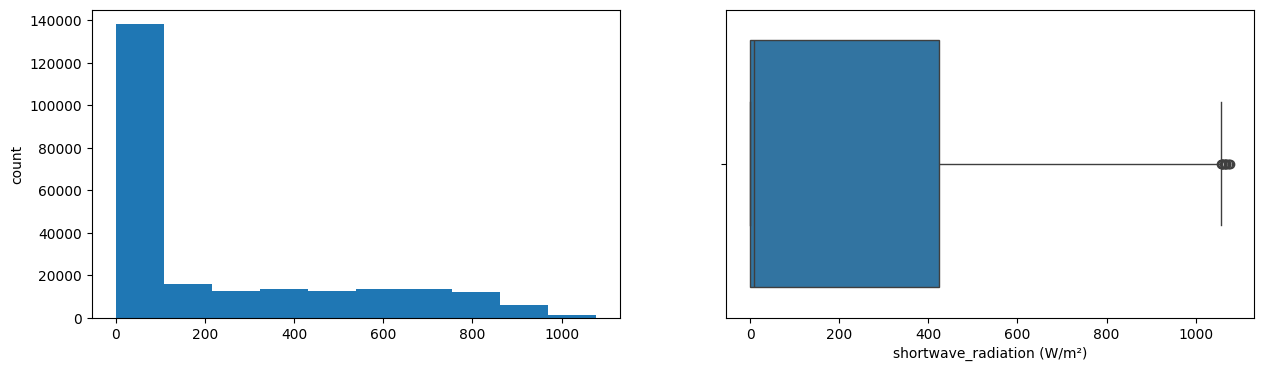

direct_radiation (W/m²)
Skew : 1.48


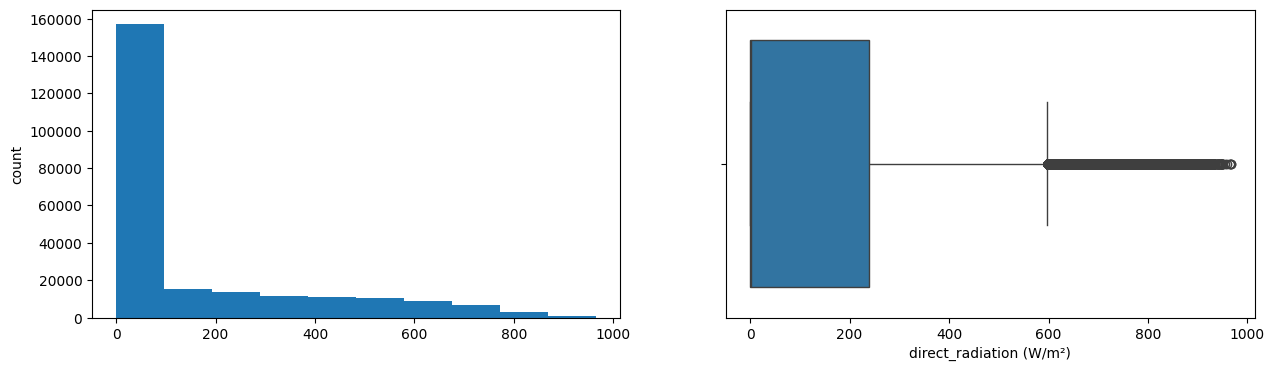

diffuse_radiation (W/m²)
Skew : 1.19


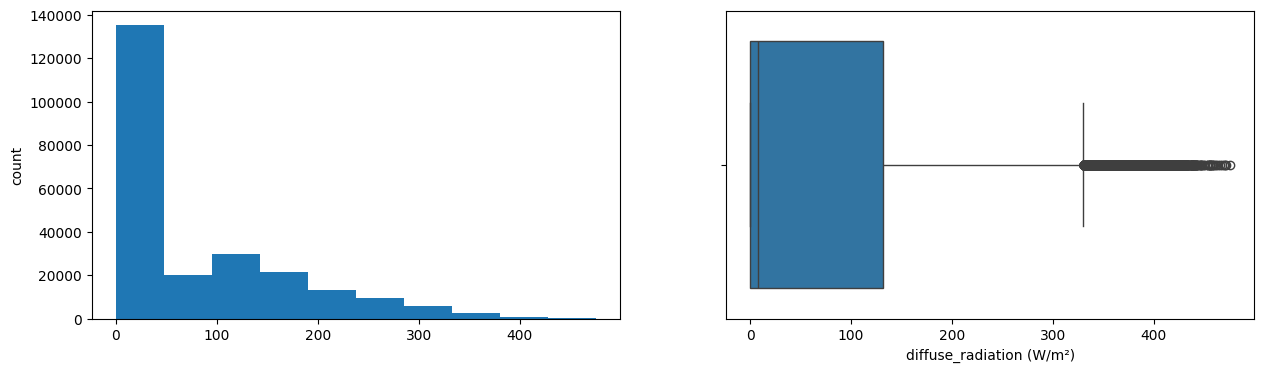

direct_normal_irradiance (W/m²)
Skew : 1.04


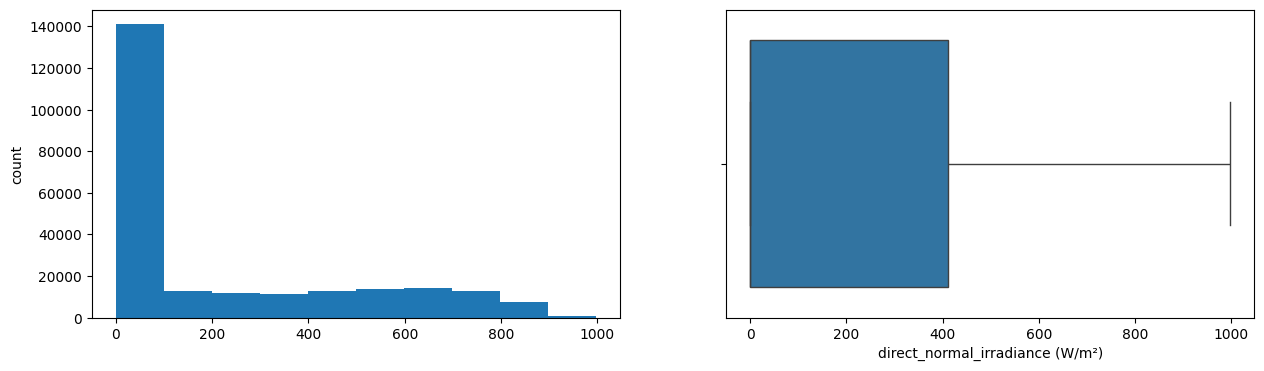

windspeed_10m (km/h)
Skew : 1.27


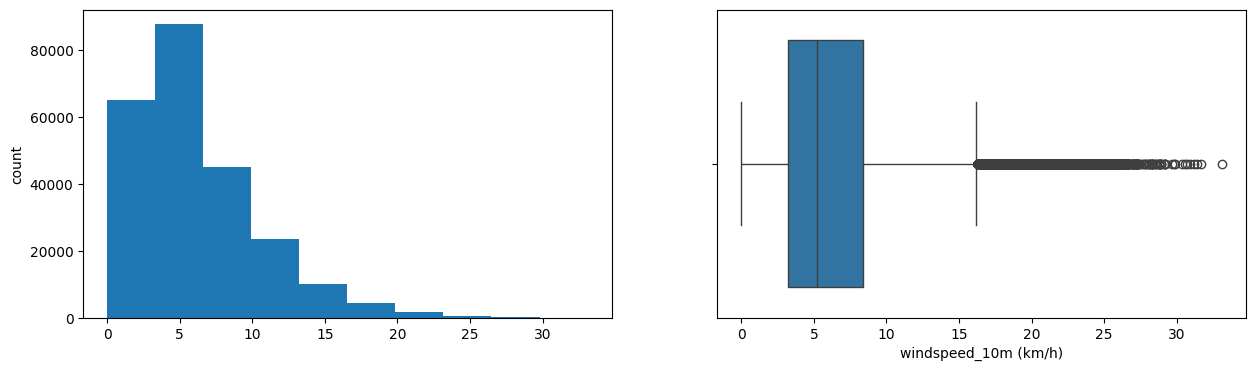

windspeed_100m (km/h)
Skew : 0.97


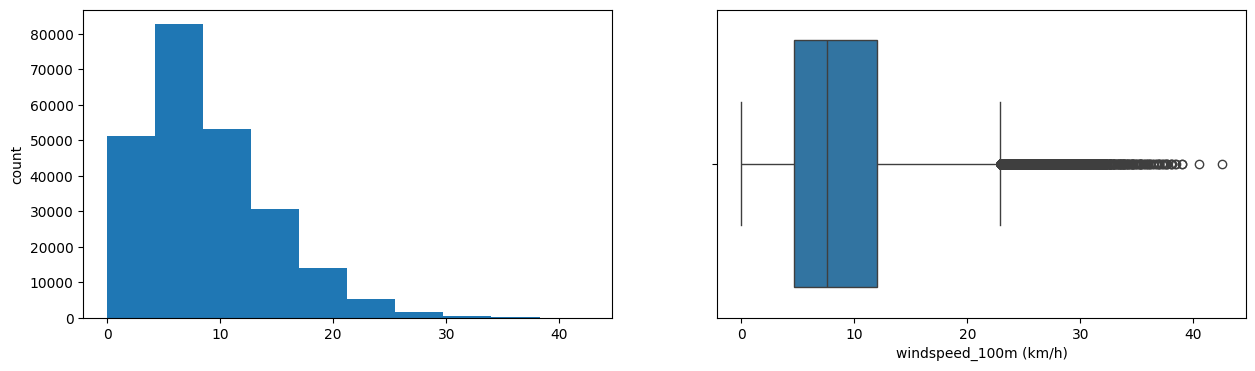

winddirection_10m (°)
Skew : 0.04


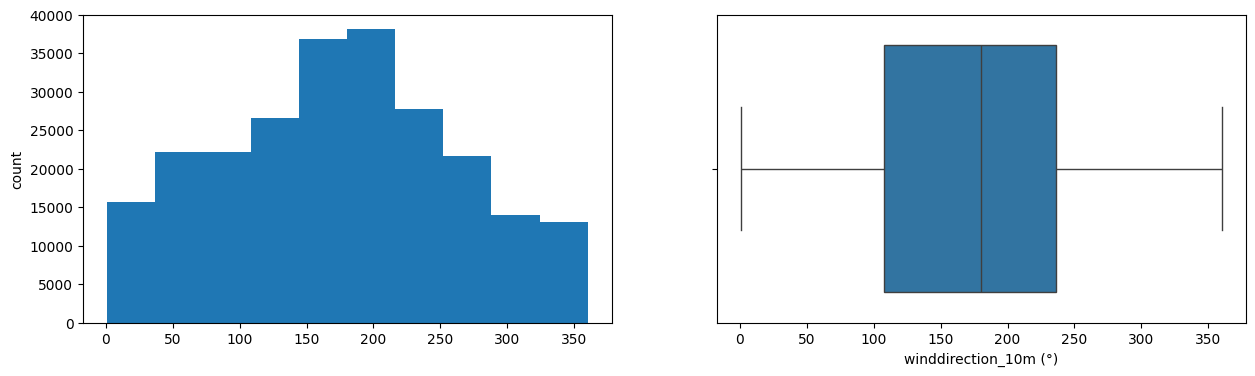

winddirection_100m (°)
Skew : 0.09


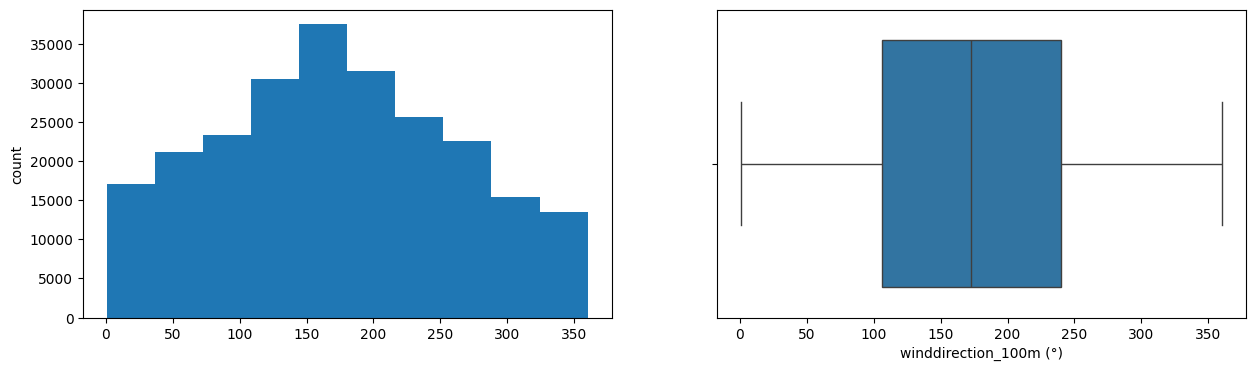

windgusts_10m (km/h)
Skew : 0.84


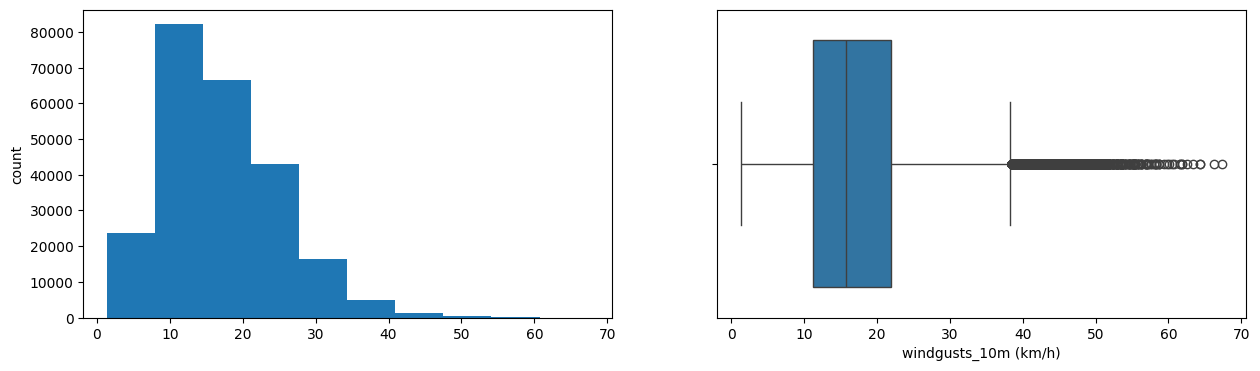

et0_fao_evapotranspiration (mm)
Skew : 1.11


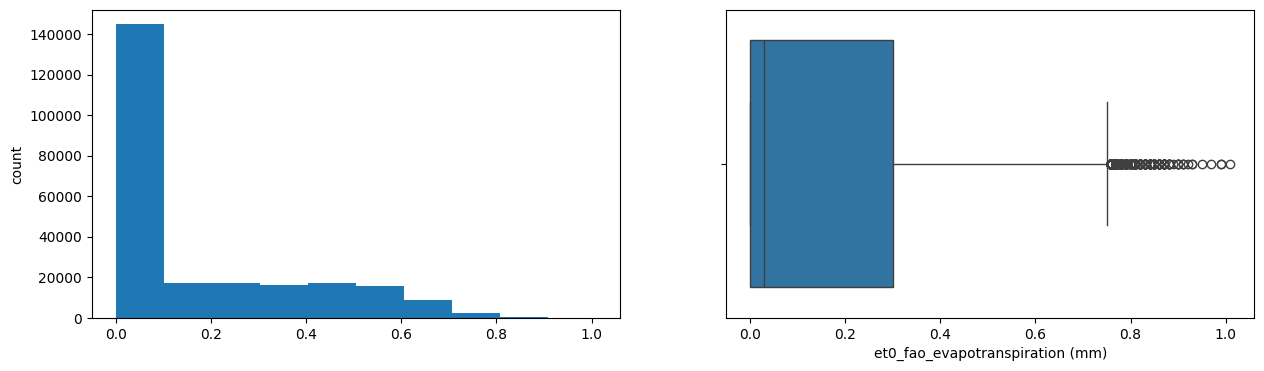

vapor_pressure_deficit (kPa)
Skew : 2.16


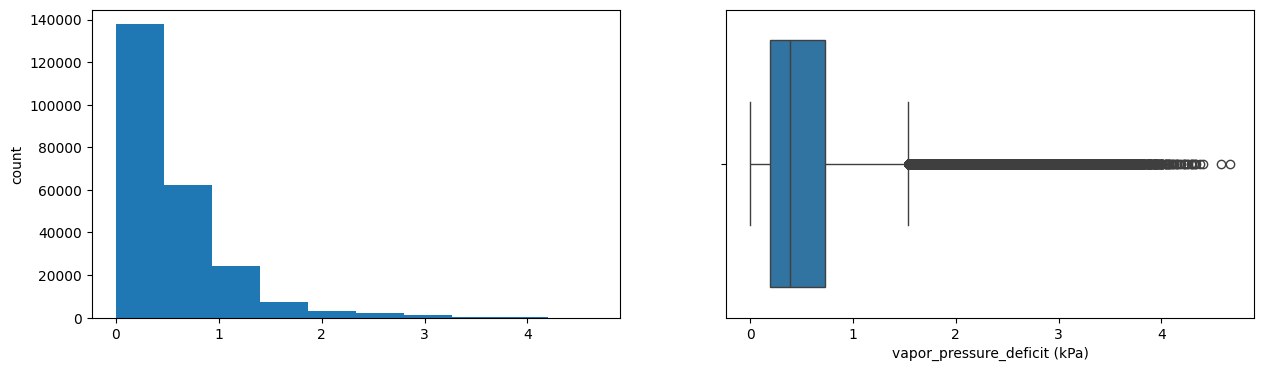

soil_temperature_0_to_7cm (°C)
Skew : -0.21


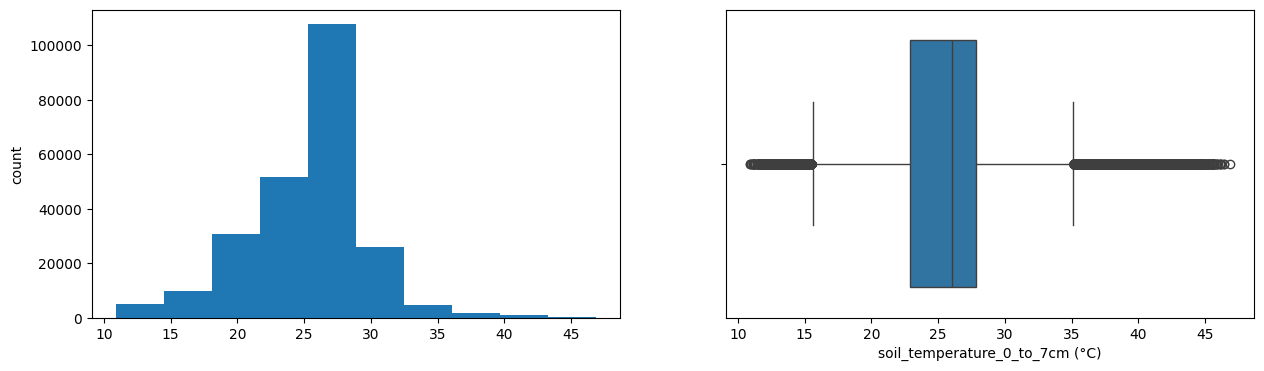

soil_temperature_7_to_28cm (°C)
Skew : -0.91


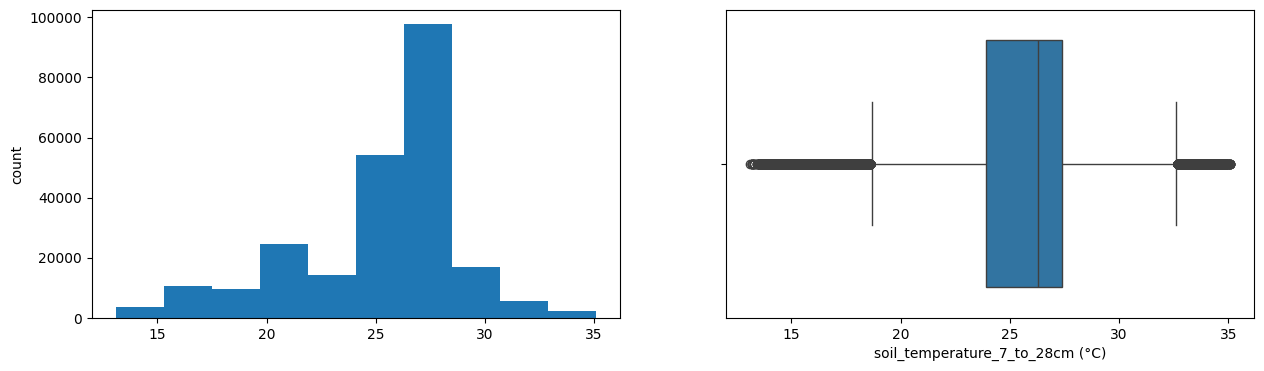

soil_temperature_28_to_100cm (°C)
Skew : -1.02


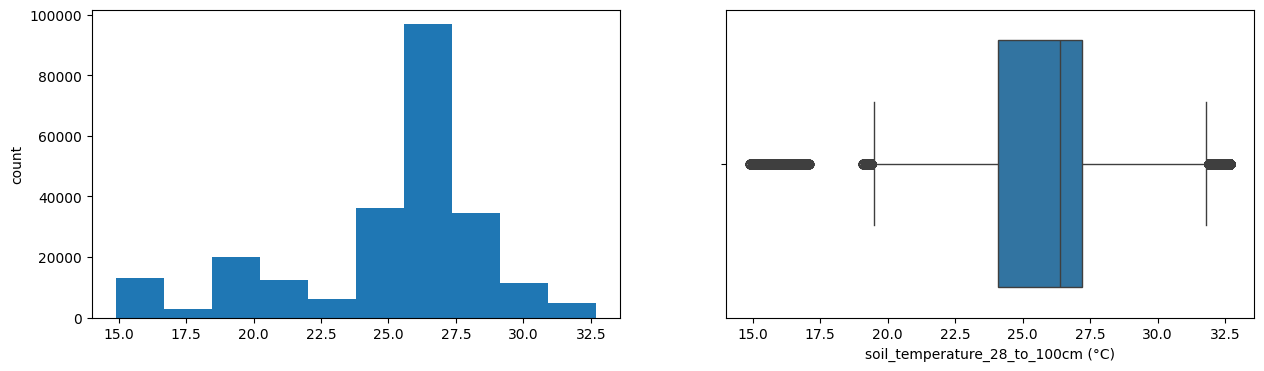

soil_temperature_100_to_255cm (°C)
Skew : -1.07


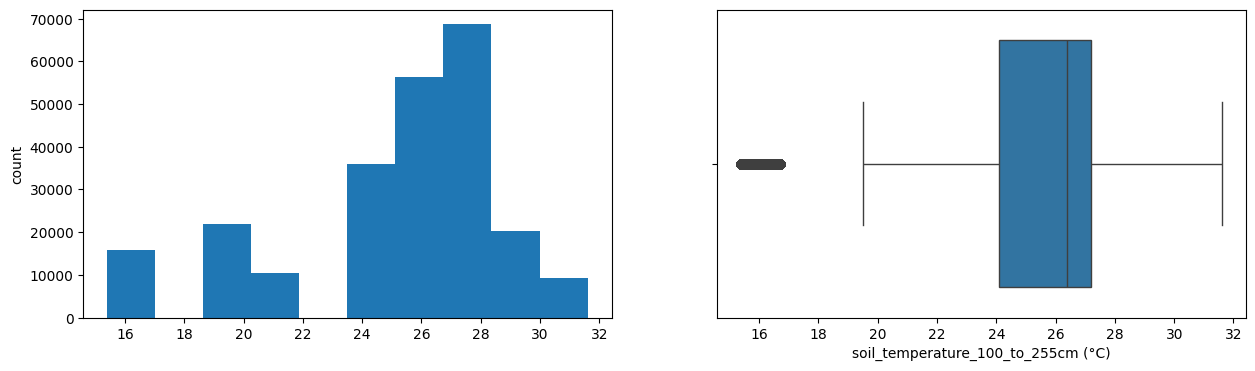

soil_moisture_0_to_7cm (m³/m³)
Skew : -0.71


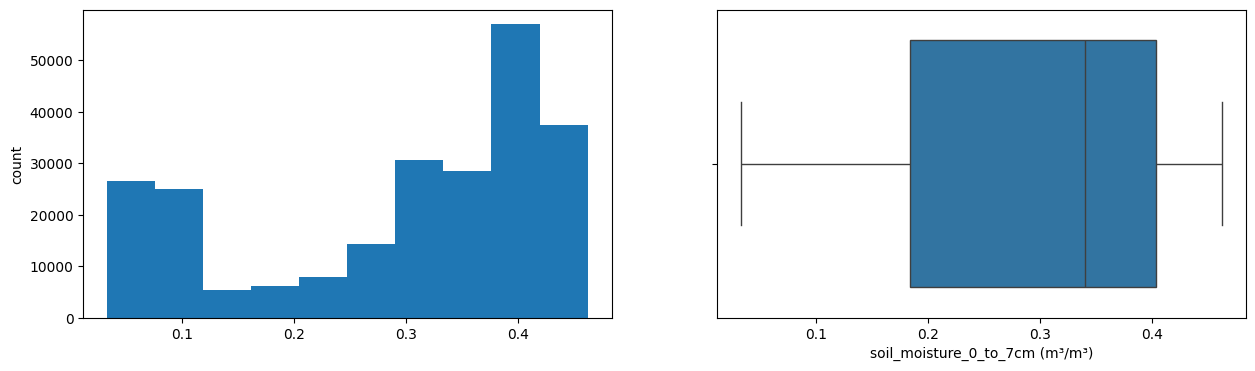

soil_moisture_7_to_28cm (m³/m³)
Skew : -0.68


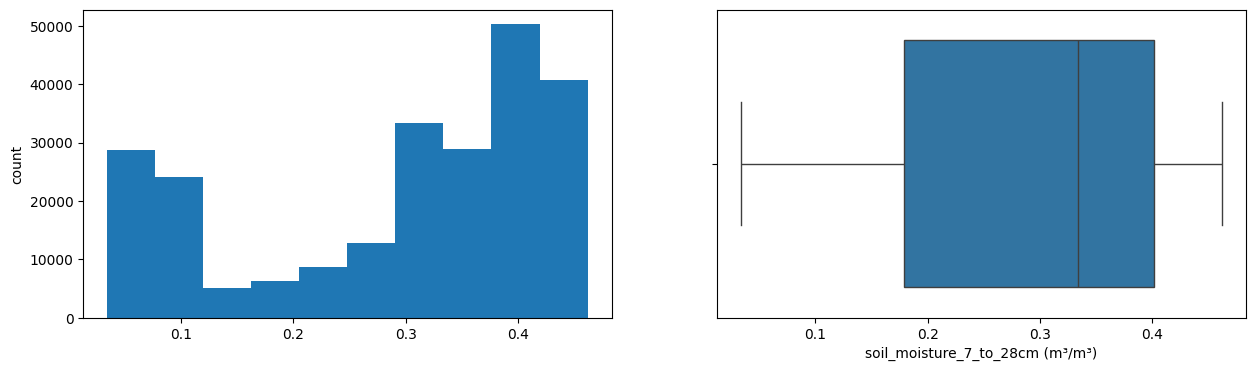

soil_moisture_28_to_100cm (m³/m³)
Skew : -0.61


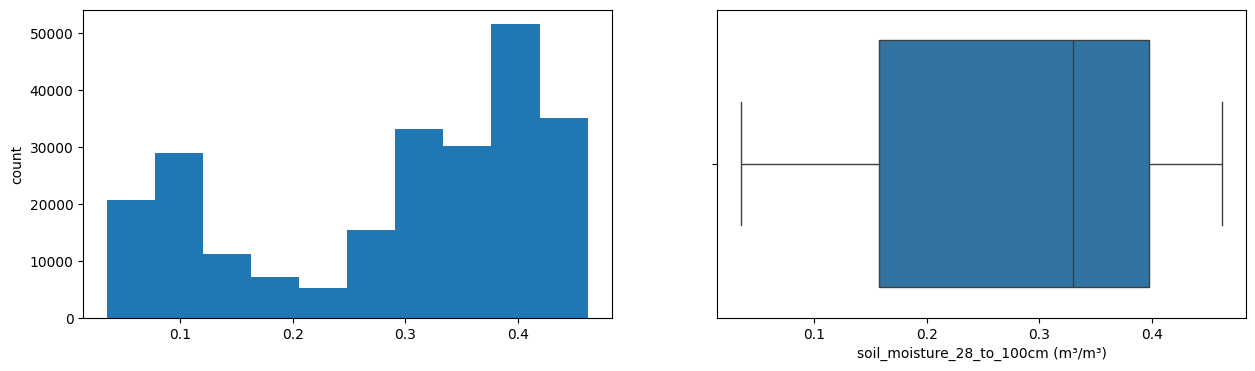

soil_moisture_100_to_255cm (m³/m³)
Skew : -0.9


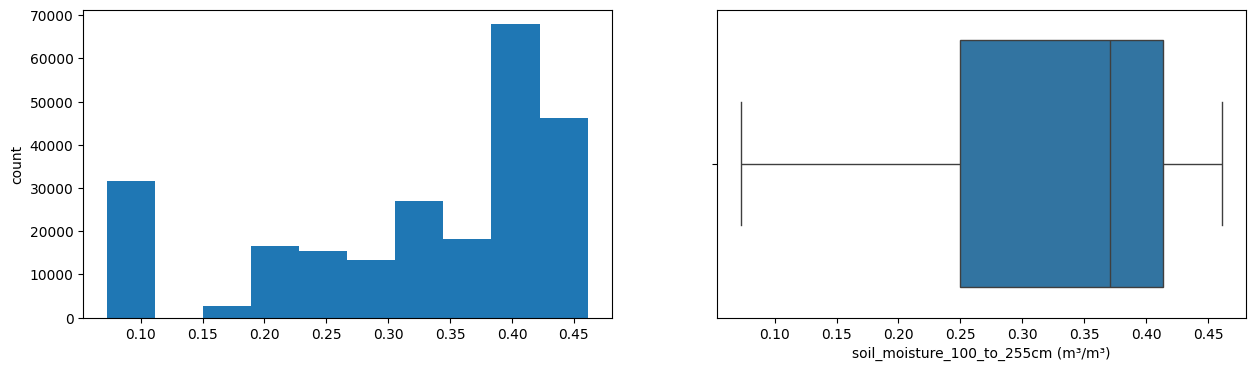

city
Skew : 0.13


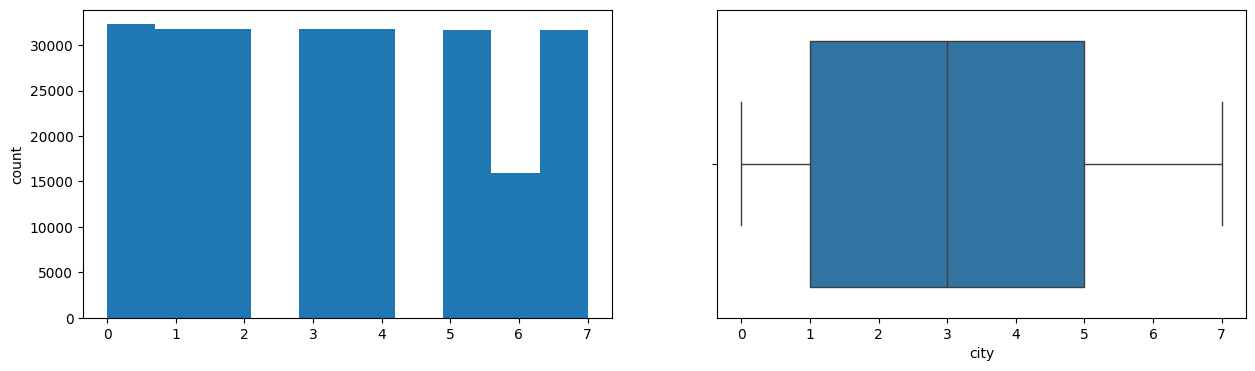

In [796]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_columns = train.select_dtypes(include=["int64", "float64"]).columns
for col in numeric_columns:
    print(col)
    print("Skew :", round(train[col].skew(), 2))
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    train[col].hist(grid=False)
    plt.ylabel("count")
    plt.subplot(1, 2, 2)
    sns.boxplot(x=train[col])
    plt.show()

# **Data Preprocessing**


## **Dropping Snowfall**

As said above, the snowfall feature is basically not usable due to how it only has one value, which is `0.0`, so we drop it.


In [797]:
train["snowfall (cm)"].unique()

array([ 0., nan])

In [798]:
train.drop("snowfall (cm)", axis=1, inplace=True)

## **Missing Values**

The data has some missing values, however due to the scale of it, the proportions of the missing data compared to the size of the set is overall deemed inconsequential, as not even one of the features has >1% of its data missing.

As a result of the above, I believe imputing the data would've ended us up with an inconsequential imputation overall with a net loss in terms of result to compute ratio (i.e., a lot of the data _is_ there, so doing, for example, a MICE would just be a waste of time and compute). As such, handling was done via a list-wise drop.

The resulting data retained 99.76% of the original data, which isn't even a loss of 1% of the original data, so I deemed it a good enough fit to the original.


In [799]:
display(
    pd.DataFrame(
        ((train.isnull().sum() / len(train)) * 100).sort_values(ascending=False),
        columns=["proportion"],
    )
)

,proportion
winddirection_10m (°),0.188984
winddirection_100m (°),0.108949
temperature_2m (°C),0.049865
relativehumidity_2m (%),0.049865
soil_moisture_100_to_255cm (m³/m³),0.049865
soil_moisture_28_to_100cm (m³/m³),0.049865
soil_moisture_7_to_28cm (m³/m³),0.049865
soil_moisture_0_to_7cm (m³/m³),0.049865
soil_temperature_100_to_255cm (°C),0.049865
soil_temperature_28_to_100cm (°C),0.049865


<Axes: >

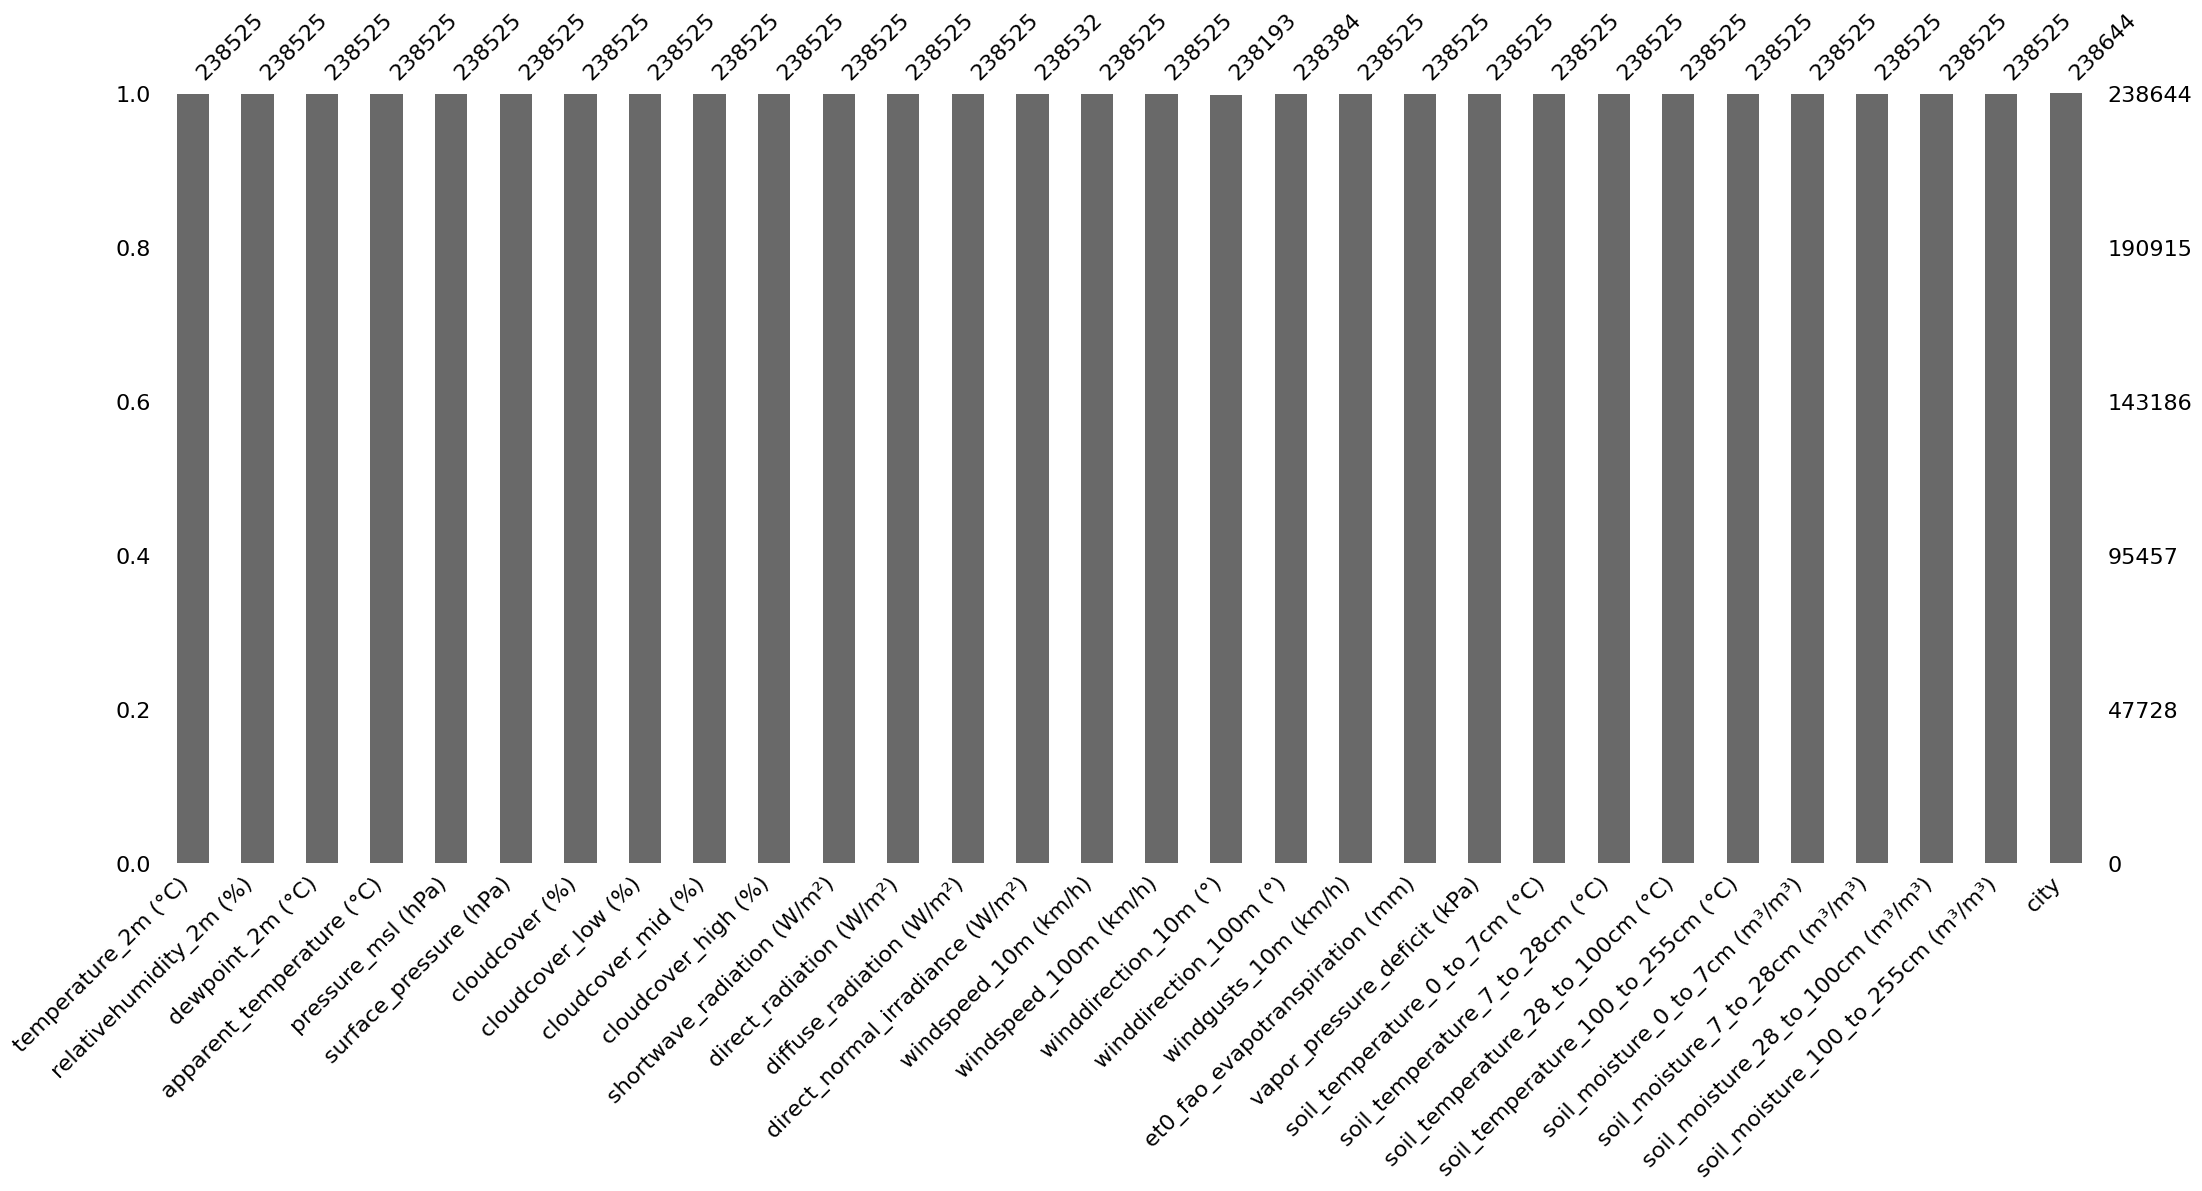

In [800]:
msno.bar(train)

<Axes: >

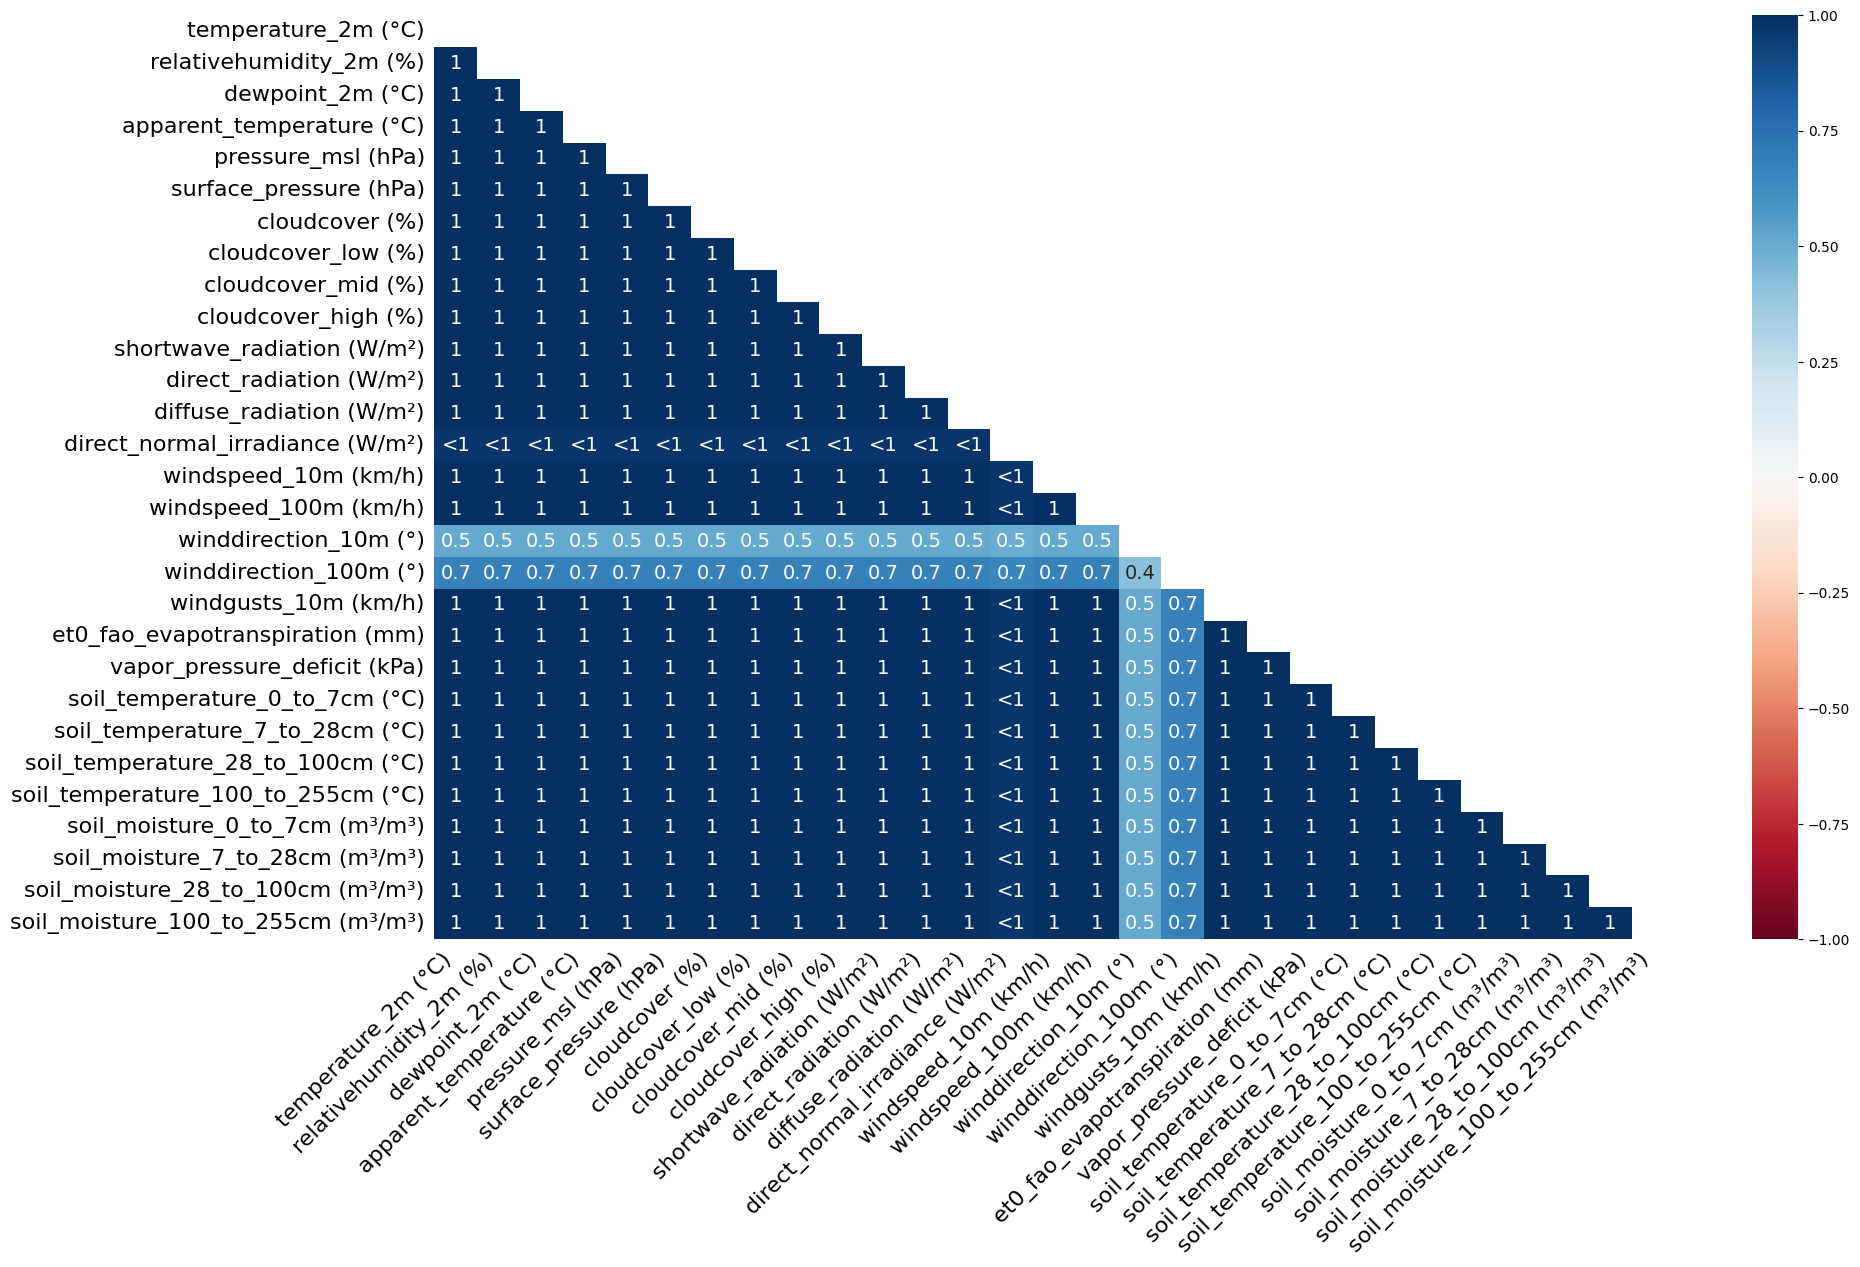

In [801]:
msno.heatmap(train)

In [802]:
prior_len = len(train)

In [803]:
train.dropna(inplace=True)
print(f"Retention: {(len(train)/prior_len)*100:.2f}%")

Retention: 99.76%


## **Skew Handling**

To address the skew, I did two things:

1. `z-score filtering`: I filtered the data based on their z-score on a threshold of $\sigma = 2$, so anything beyond 2 standard deviations away from the mean is trimmed off. The rationale behind this was that, by trimming off the "fat" off the distribution, which is the tail here, we'll achieve a much more "normal"-like result.

The result trimmed off about half of the data, resulting in a retention of $\approx55.8\%$ of the data. However, this dataset is still fairly huge, 133k-ish instances, just without as heavy of tails seen prior in the dataset, so I thought that it's good enough in representing the original.

2. `QuantileTransformer`: I also applied a QuantileTransformer scaler on the trimmed data with the target to a normal distribution. For this, the reasoning behind it was that, `QuantileTransformer` can be set to do scaling in such a way that it targets a gaussian-like mapped domain.

I.e., see this comparison from sklearn's [docs](https://scikit-learn.org/dev/auto_examples/preprocessing/plot_all_scaling.html), here's the original:

<img src="./image-1.png" style="width: 50vw">

Here's after scaling:

<img src="./image.png" style="width: 50vw">

Also, `city` was excluded from scaling because label encodings generally can't (shouldn't, since, well, they really don't have a scale in the first place anyway) be scaled.


In [804]:
from scipy.stats import zscore
import numpy as np


def symmetric_zscore_filter(series, threshold=2):
    z_scores = np.abs(zscore(series))
    return series[z_scores < threshold]

In [805]:
train.dropna(inplace=True)

In [806]:
train

,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),pressure_msl (hPa),surface_pressure (hPa),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),windspeed_10m (km/h),windspeed_100m (km/h),winddirection_10m (°),winddirection_100m (°),windgusts_10m (km/h),et0_fao_evapotranspiration (mm),vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),city
0,28.8,78.0,24.6,33.7,1010.8,1010.3,50.0,13.0,17.0,93.0,460.0,190.0,270.0,222.1,11.4,15.3,204.0,204.0,25.9,0.33,0.88,29.0,26.7,26.9,27.0,0.386,0.391,0.398,0.397,3
1,24.9,97.0,24.4,31.9,1008.5,1010.2,20.0,2.0,28.0,4.0,0.0,0.0,0.0,0.0,2.6,5.8,164.0,120.0,7.6,0.00,0.09,25.8,27.5,27.0,26.5,0.344,0.348,0.316,0.401,2
2,28.7,64.0,21.3,34.4,1013.6,1015.3,76.0,32.0,39.0,79.0,779.0,618.0,161.0,720.9,7.6,9.4,8.0,7.0,18.7,0.56,1.41,28.7,25.9,26.4,26.1,0.300,0.286,0.328,0.418,2
3,24.9,90.0,23.1,28.3,1012.8,987.2,65.0,48.0,0.0,73.0,0.0,0.0,0.0,0.0,14.5,18.7,113.0,115.0,27.7,0.01,0.31,24.8,25.1,25.3,25.4,0.076,0.077,0.068,0.095,7
4,12.7,92.0,11.5,12.8,1016.6,743.8,100.0,81.0,80.0,83.0,0.0,0.0,0.0,0.0,0.5,1.9,225.0,292.0,22.7,0.00,0.11,14.6,16.0,16.8,16.5,0.328,0.334,0.350,0.340,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238639,26.6,89.0,24.6,33.2,1009.9,986.8,26.0,8.0,14.0,33.0,0.0,0.0,0.0,0.0,4.4,7.6,189.0,185.0,11.2,0.00,0.38,24.8,25.9,26.7,26.8,0.321,0.327,0.292,0.319,4
238640,29.9,79.0,25.9,38.2,1011.7,986.5,38.0,23.0,27.0,3.0,992.0,873.0,119.0,922.1,10.3,10.7,209.0,213.0,24.5,0.70,0.88,28.8,28.0,28.0,28.0,0.084,0.081,0.089,0.077,7
238641,26.8,85.0,24.1,35.3,1009.2,1010.9,33.0,3.0,3.0,94.0,26.0,10.0,16.0,182.9,3.3,4.8,49.0,48.0,10.4,0.03,0.52,27.9,27.6,26.5,26.4,0.353,0.351,0.328,0.409,2
238642,28.4,83.0,25.3,34.3,1009.4,984.2,61.0,22.0,37.0,62.0,710.0,607.0,103.0,797.8,12.9,14.5,150.0,145.0,25.2,0.47,0.64,28.0,27.5,27.3,27.3,0.082,0.071,0.082,0.103,7


In [807]:
prior_len = len(train)

temperature_2m (°C)
Skew : -0.95


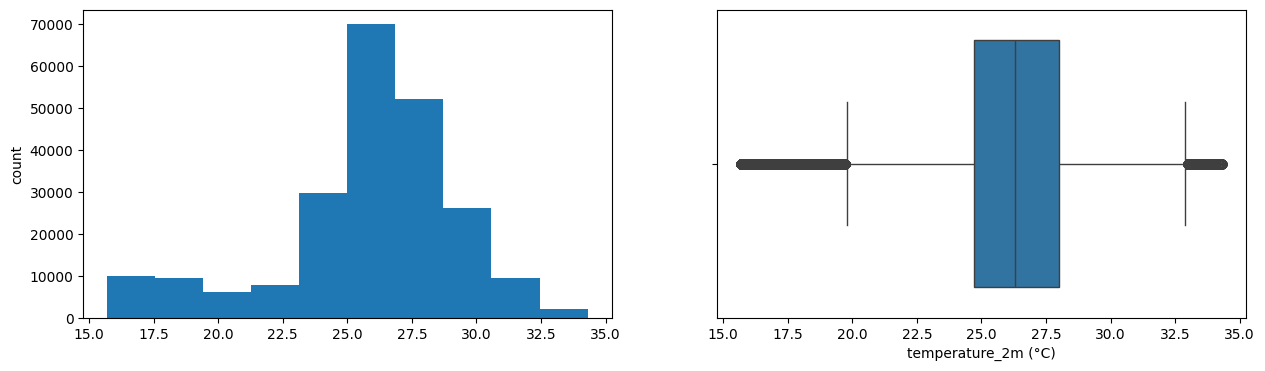

relativehumidity_2m (%)
Skew : -0.68


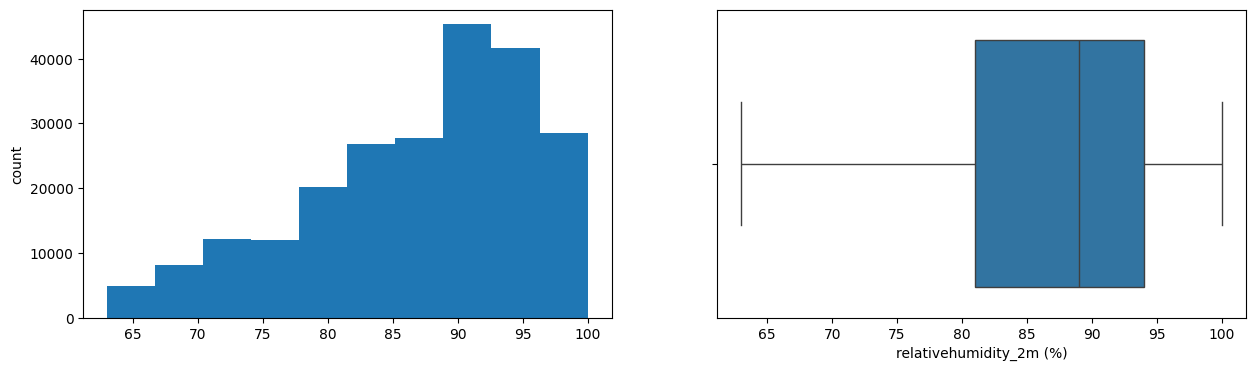

dewpoint_2m (°C)
Skew : -1.3


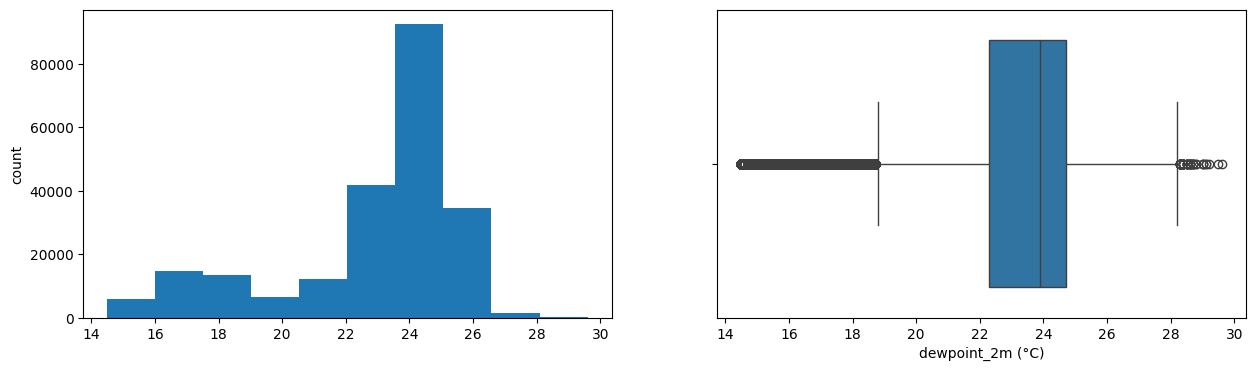

apparent_temperature (°C)
Skew : -1.05


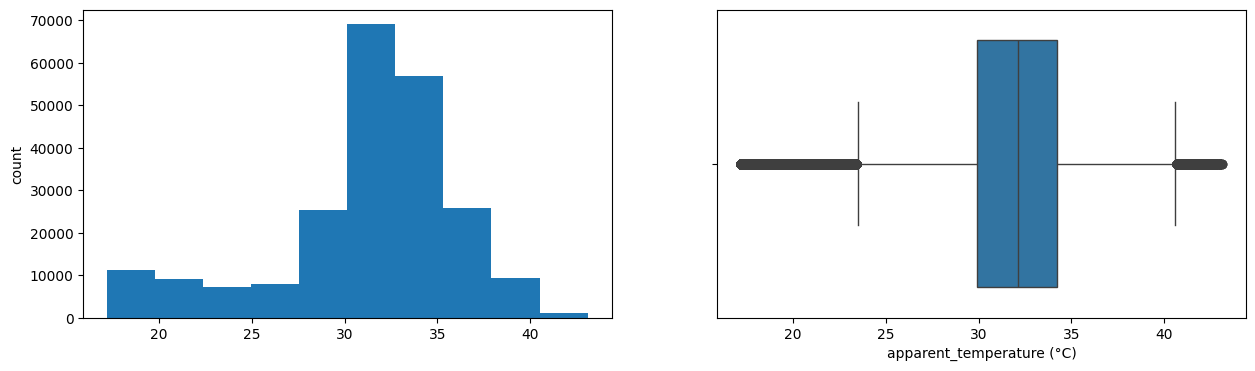

pressure_msl (hPa)
Skew : 0.21


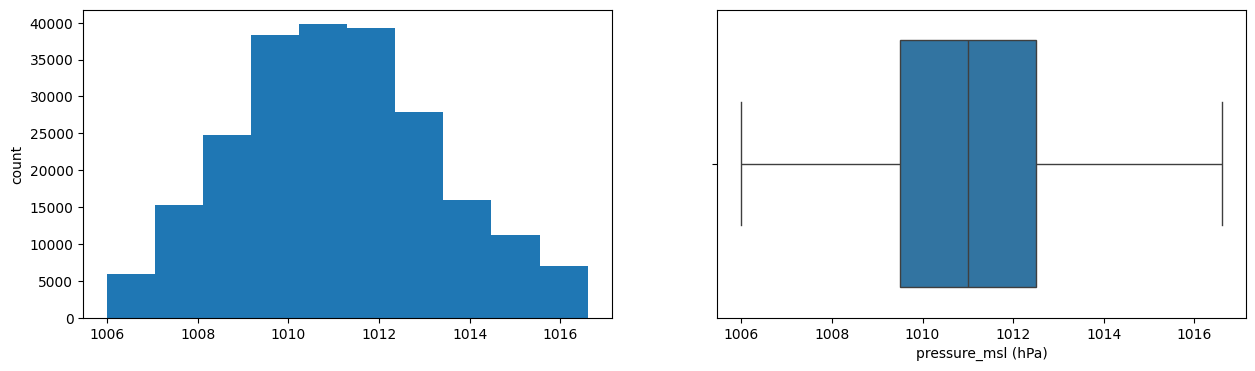

surface_pressure (hPa)
Skew : -1.77


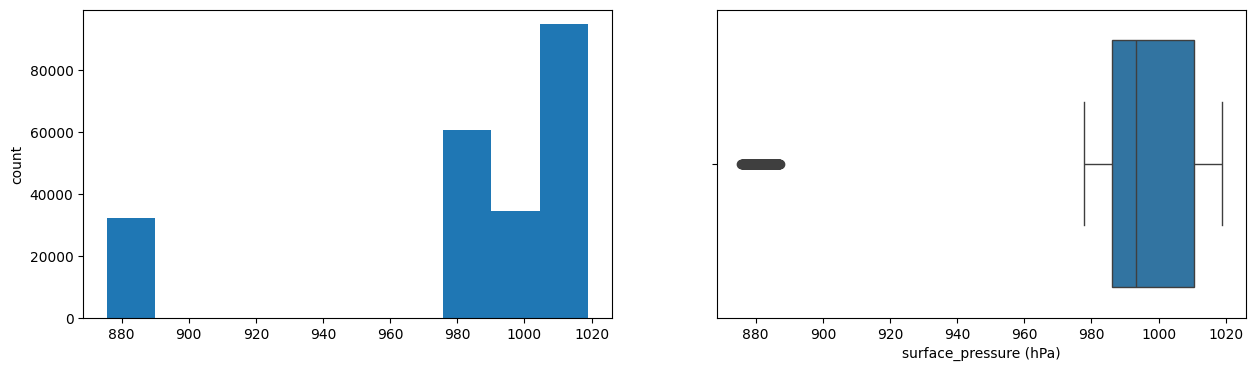

cloudcover (%)
Skew : 0.11


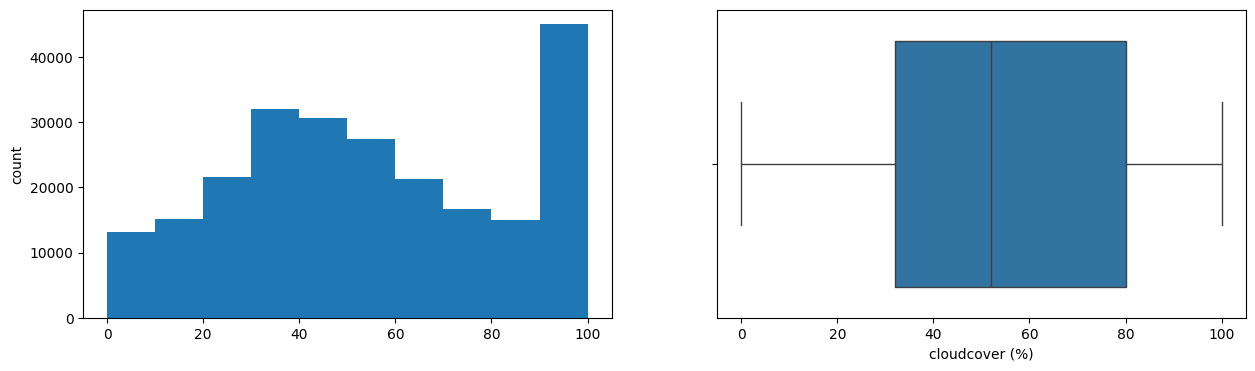

cloudcover_low (%)
Skew : 1.31


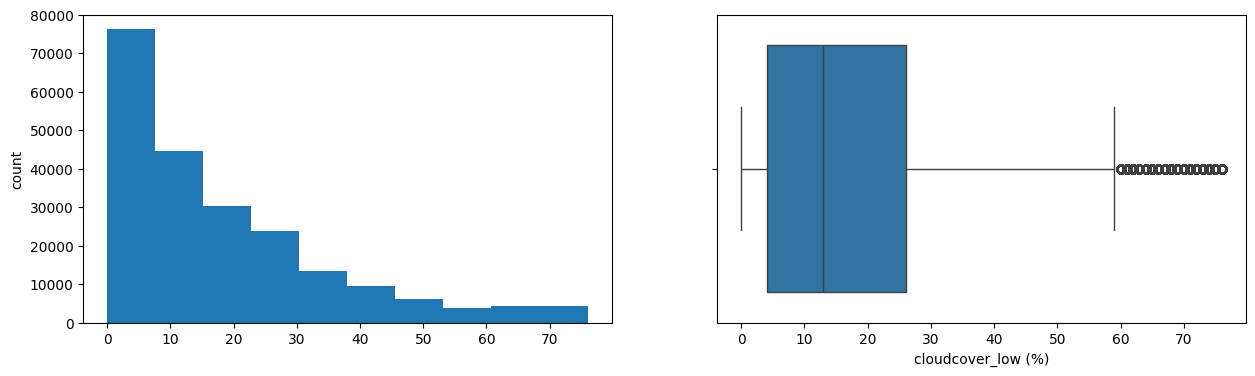

cloudcover_mid (%)
Skew : 1.13


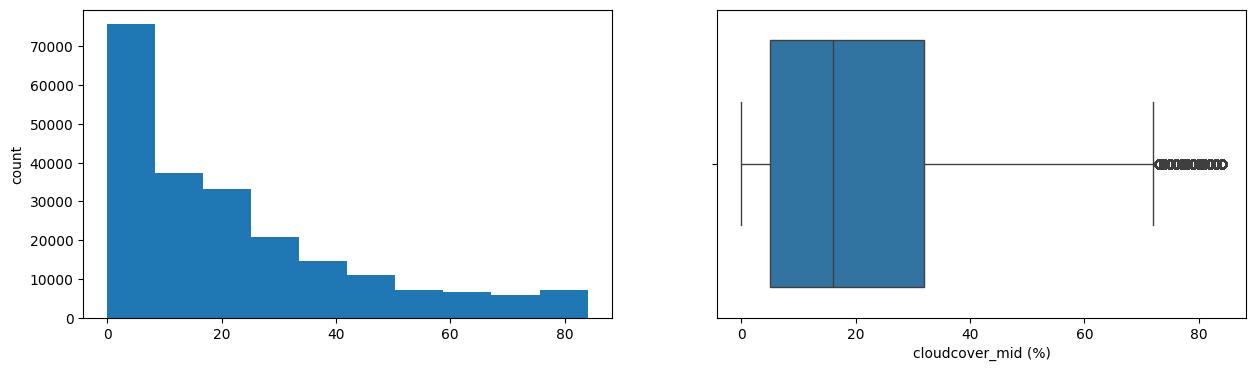

cloudcover_high (%)
Skew : -0.85


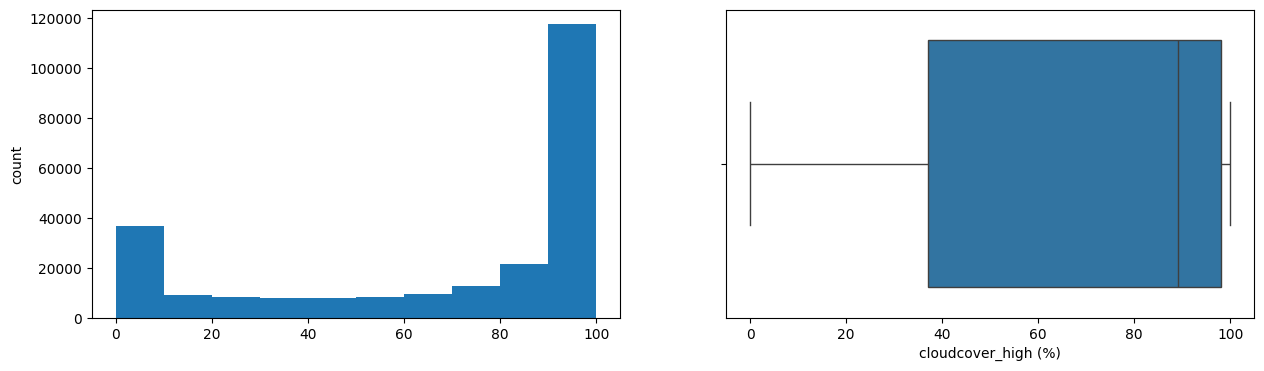

shortwave_radiation (W/m²)
Skew : 1.14


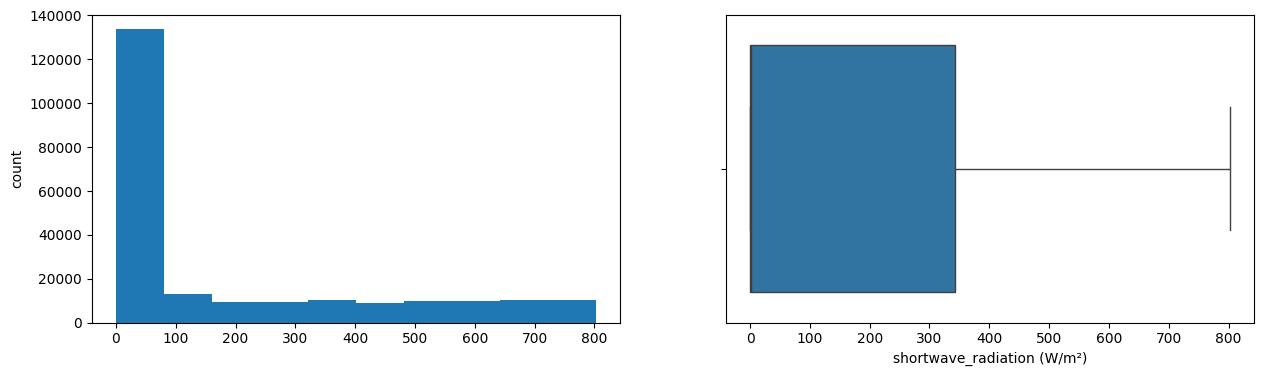

direct_radiation (W/m²)
Skew : 1.57


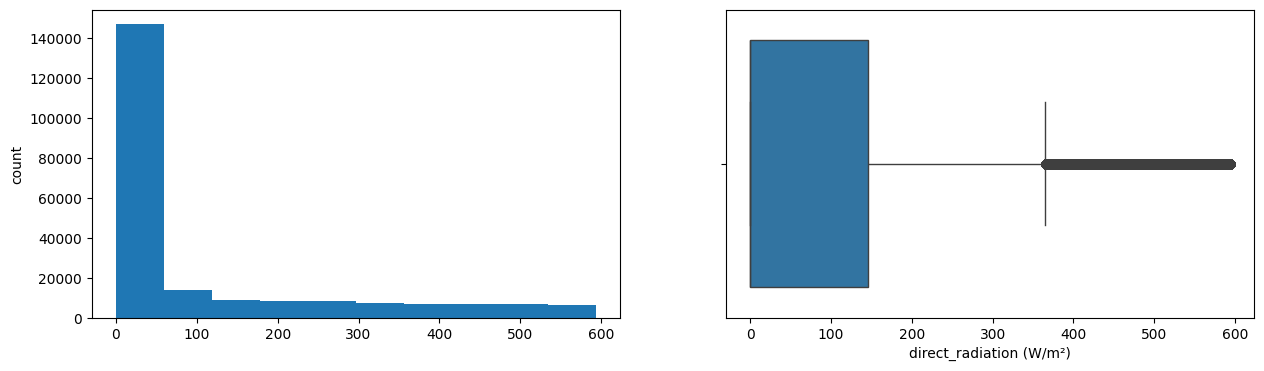

diffuse_radiation (W/m²)
Skew : 0.98


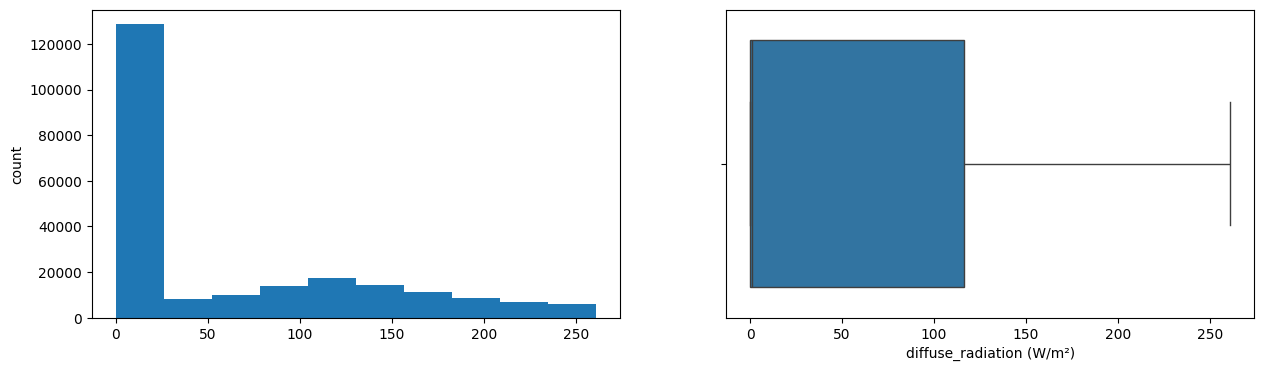

direct_normal_irradiance (W/m²)
Skew : 1.13


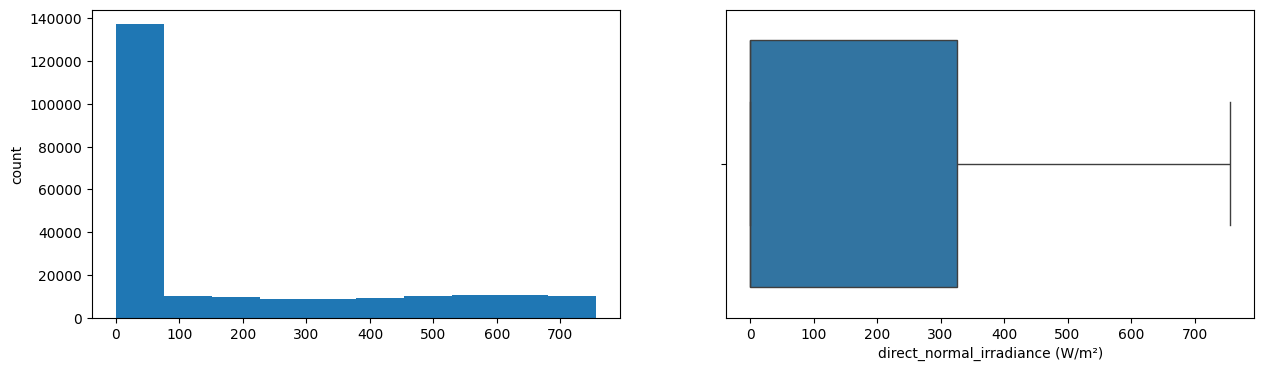

windspeed_10m (km/h)
Skew : 0.69


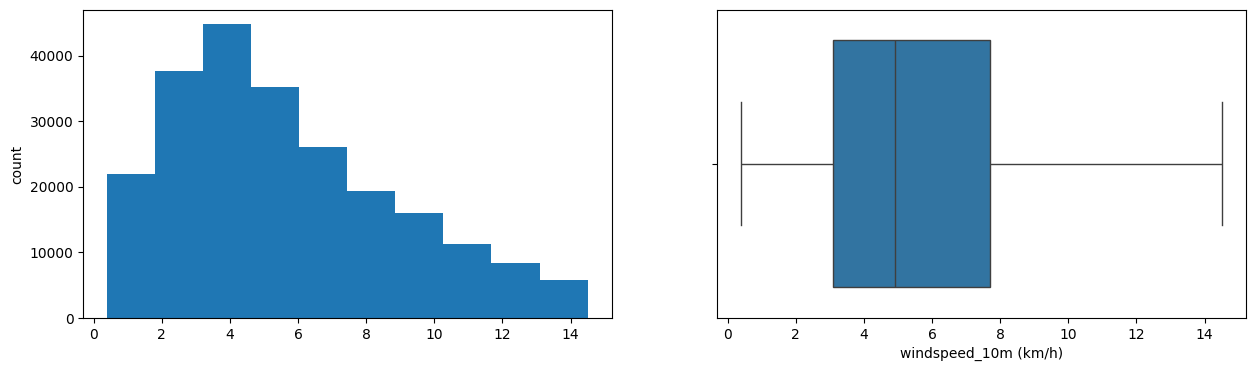

windspeed_100m (km/h)
Skew : 0.54


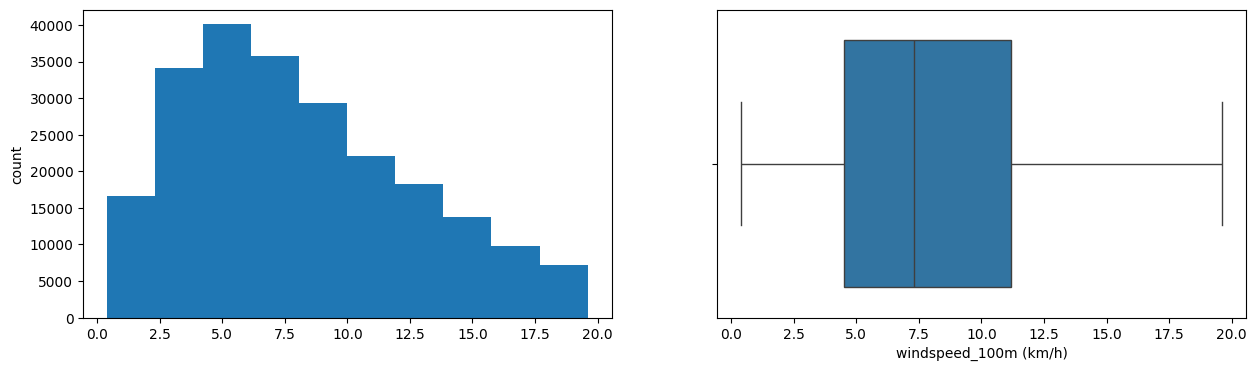

winddirection_10m (°)
Skew : -0.01


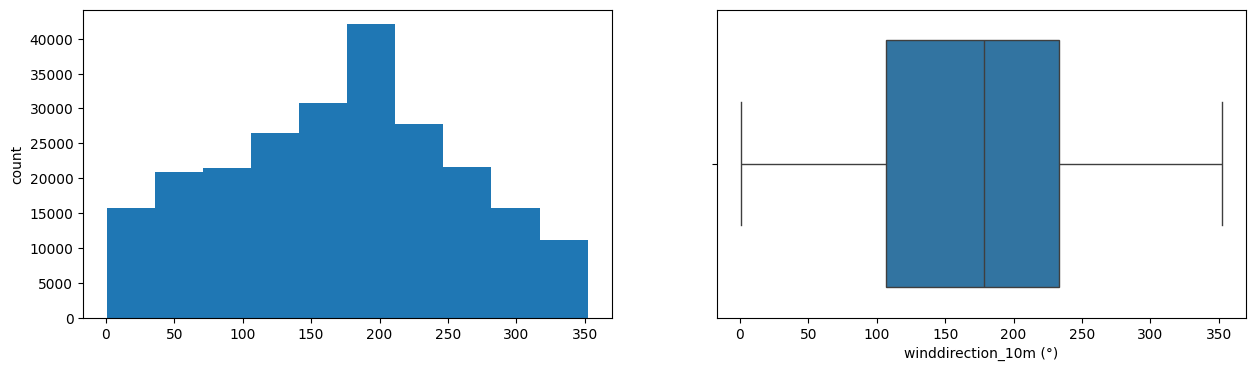

winddirection_100m (°)
Skew : 0.06


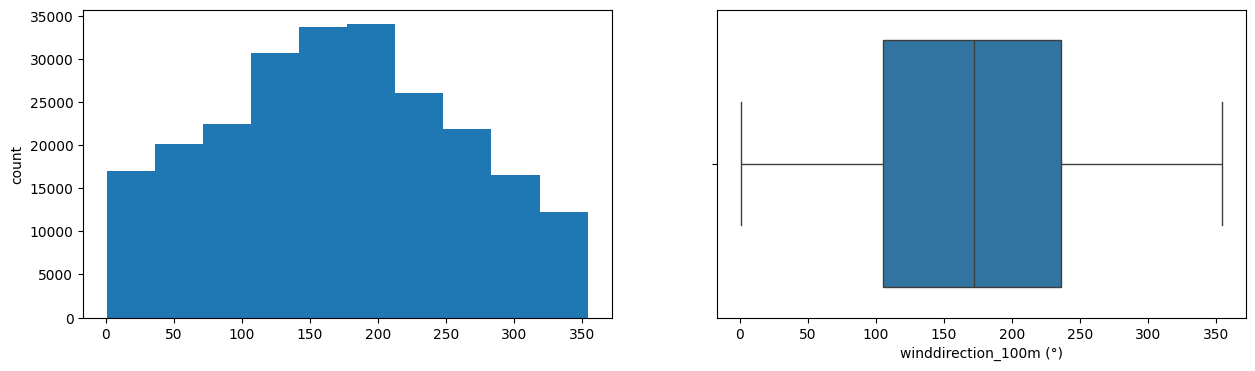

windgusts_10m (km/h)
Skew : 0.41


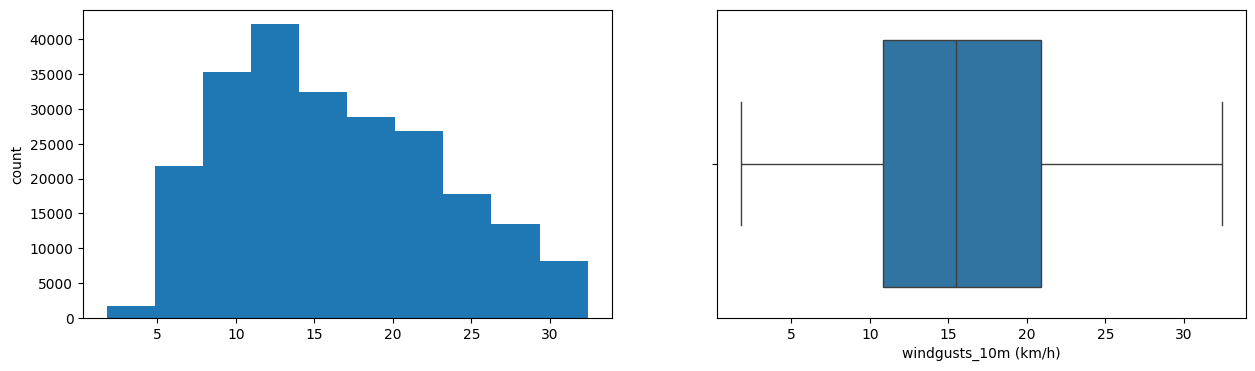

et0_fao_evapotranspiration (mm)
Skew : 1.15


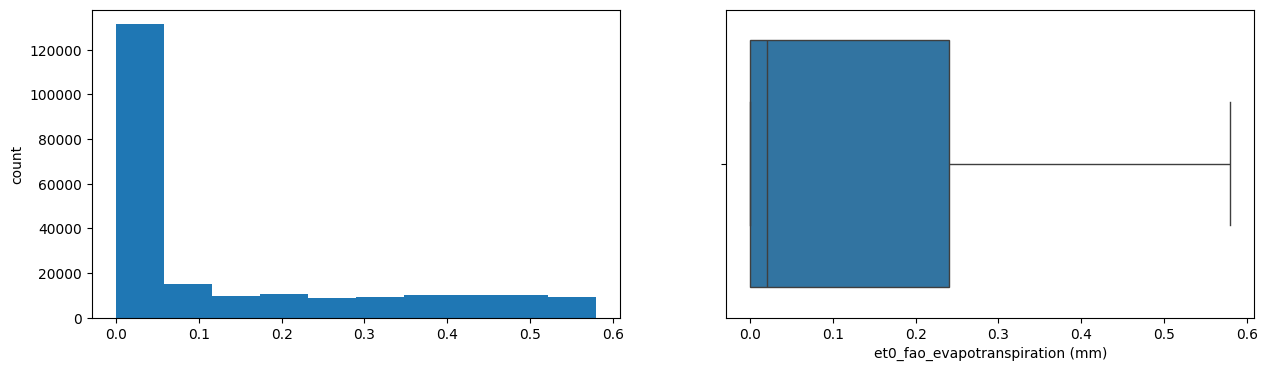

vapor_pressure_deficit (kPa)
Skew : 0.94


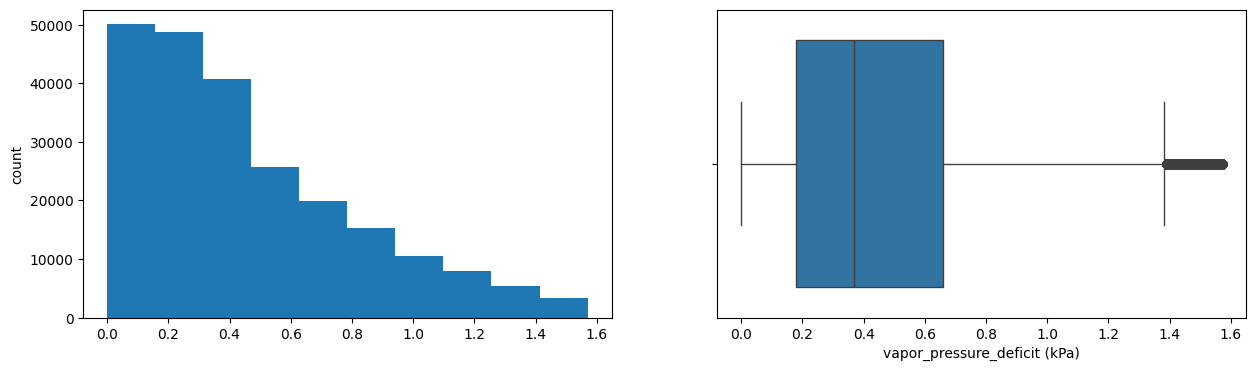

soil_temperature_0_to_7cm (°C)
Skew : -0.49


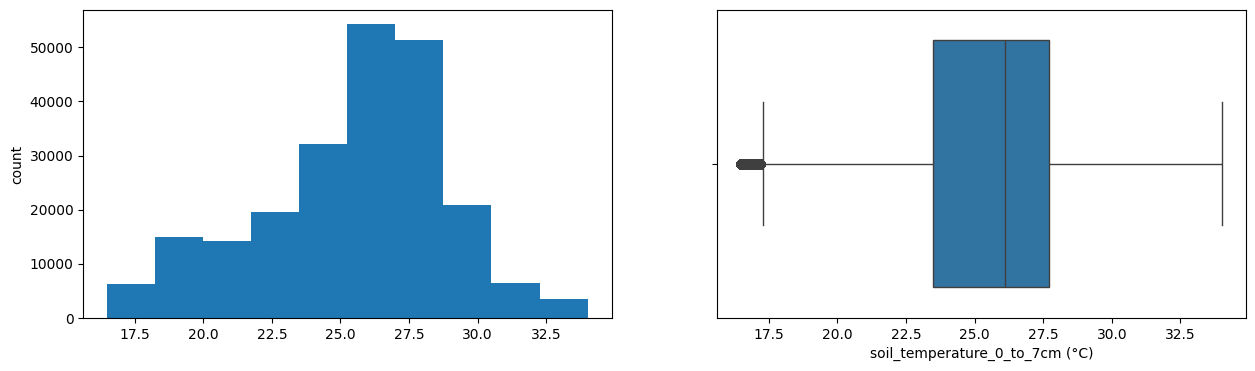

soil_temperature_7_to_28cm (°C)
Skew : -0.75


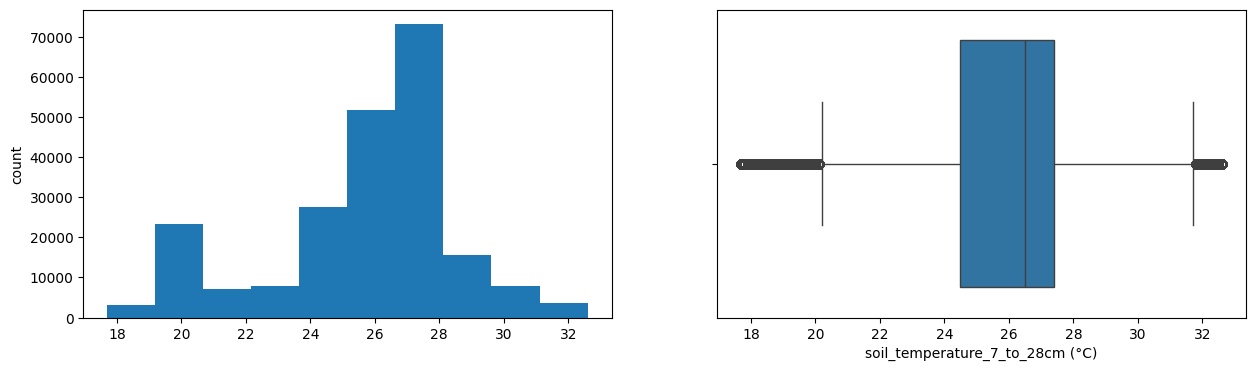

soil_temperature_28_to_100cm (°C)
Skew : -0.74


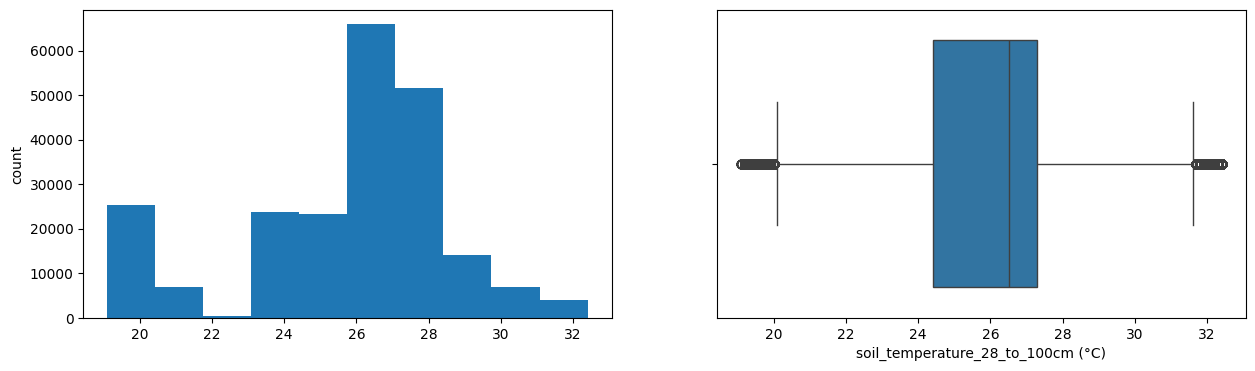

soil_temperature_100_to_255cm (°C)
Skew : -0.81


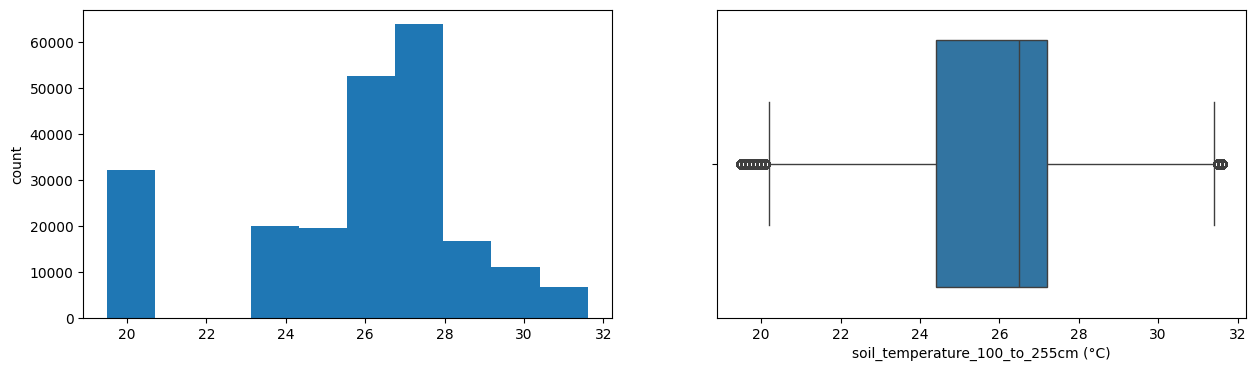

soil_moisture_0_to_7cm (m³/m³)
Skew : -0.71


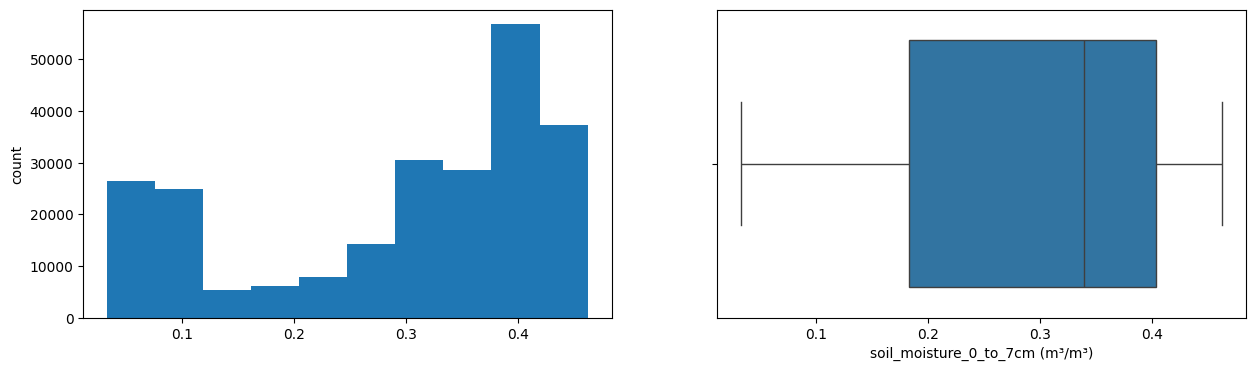

soil_moisture_7_to_28cm (m³/m³)
Skew : -0.68


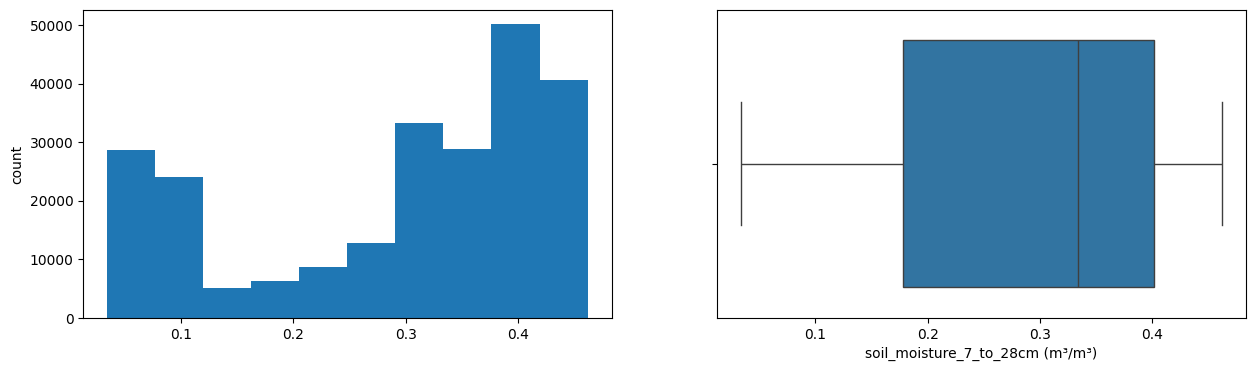

soil_moisture_28_to_100cm (m³/m³)
Skew : -0.61


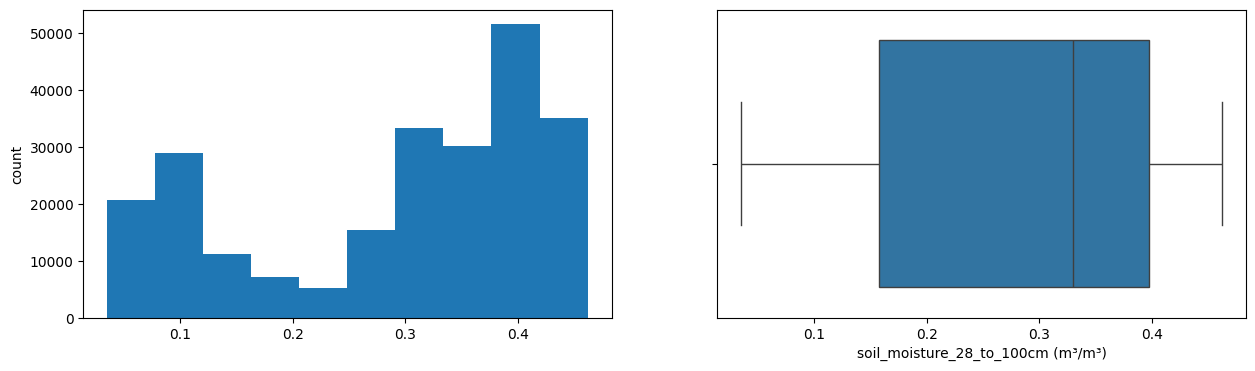

soil_moisture_100_to_255cm (m³/m³)
Skew : -1.01


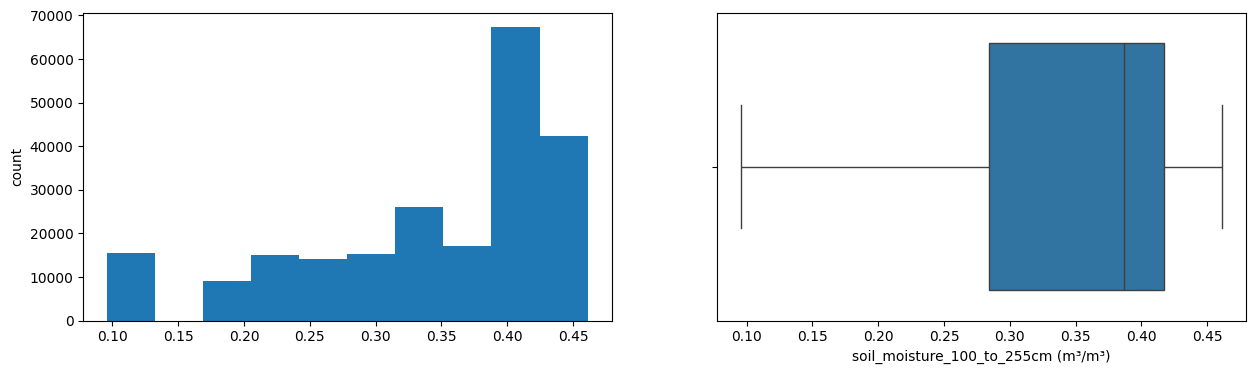

city
Skew : 0.13


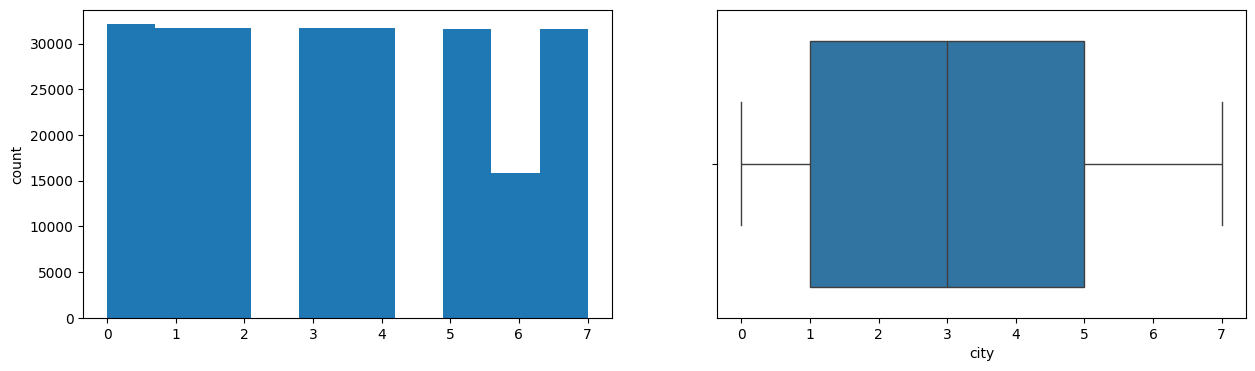

In [808]:
numeric_columns = train.select_dtypes(include=["int64", "float64"]).columns
for col in numeric_columns:
    if col != "city":
        train[col] = symmetric_zscore_filter(train[col].copy(), threshold=2)
    print(col)
    print("Skew :", round(train[col].skew(), 2))
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    train[col].hist(grid=False)
    plt.ylabel("count")
    plt.subplot(1, 2, 2)
    sns.boxplot(x=train[col])
    plt.show()

train.dropna(inplace=True)

In [809]:
len(train)

133039

In [810]:
print(f"Retention: {(len(train)/prior_len)*100:.2f}%")

Retention: 55.88%


In [811]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

scaler = QuantileTransformer(output_distribution="normal")
t_city = train["city"].copy()
t_col = train.drop("city", axis=1).columns
train = scaler.fit_transform(train.drop("city", axis=1))
train = pd.DataFrame(train, columns=t_col)
train["city"] = t_city

## **Imbalance Handling**

To handle the class imbalance on `city`, I used a `SMOTETomek` combined sampler, which uses SMOTE to oversample and Tomek links to undersample.

To briefly explain it:

1. SMOTE: Oversamples the data by using KNN on each of the minority class, then extrapolates data based on said K neighbors. The way that it extrapolates it is by grabbing one of the neighbors, then multiplying the difference between the features of said neighbor to the instance by a coefficient. This ensures that the extrapolated set is still within the plausible boundary of where the class is generally within the space.
2. Tomek links: Undersamples the data by grabbing the nearest neigbor of each of the majority class, then, if the neighbor is a minority class, that instance of the majority class is removed. This is based on the rationale that, if a majority's instance is near the minority class, then it's either a borderline, which are instances that are too close to the decision boundary, or noise.

The reasoning why I used `SMOTETomek` is because it's less aggressive compared to `SMOTEENN`, which is also another combined sampler I tried, which uses ENN for the undersampling. I've found `SMOTEENN` to work better for classification tasks rather than regression tasks from anecdotal experience, as for regressors we don't really want to remove noise so much as to remove noise that doesn't work with its local neighbors. `SMOTEENN` helps a lot when we want to remove noise off data with clear separation of classes, but not good when we don't have said clear separation.

This, along with the `QuantileTransformer`, gave us a very gaussian-like distribution for most of the features now.


temperature_2m (°C)
Skew : -0.02


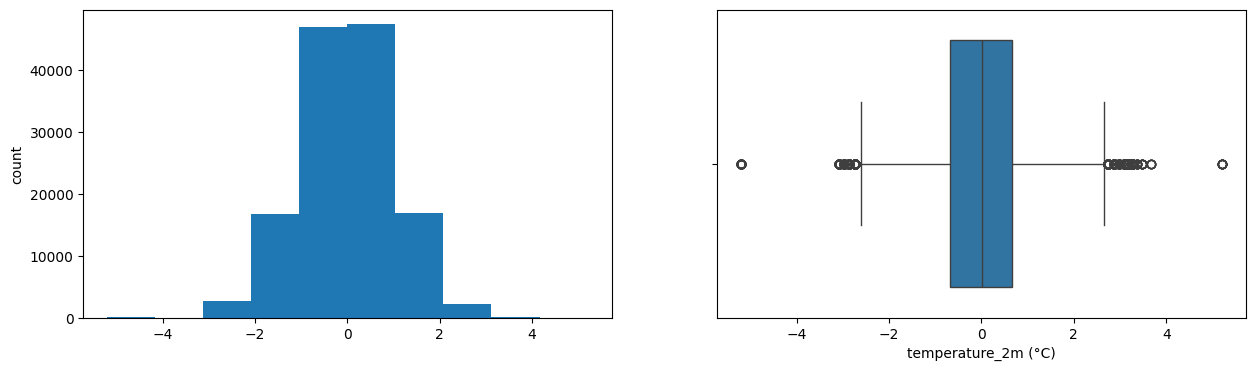

relativehumidity_2m (%)
Skew : 0.69


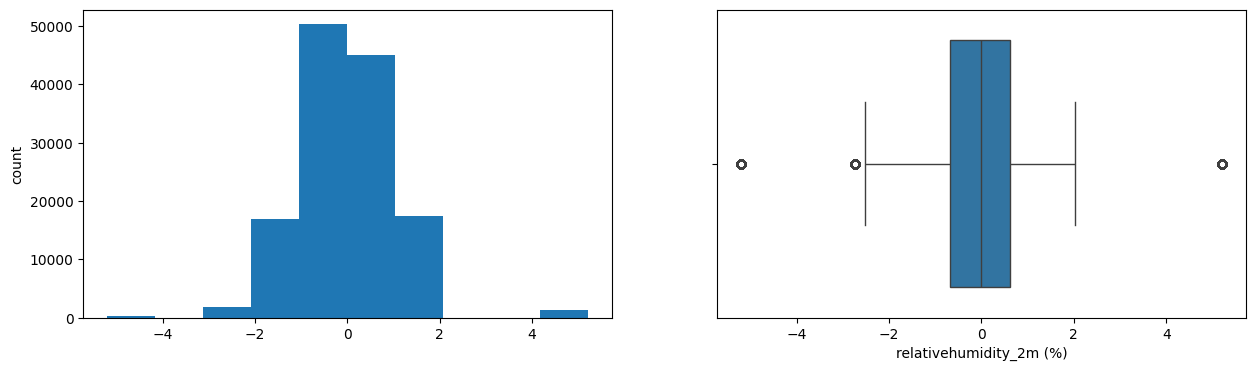

dewpoint_2m (°C)
Skew : 0.03


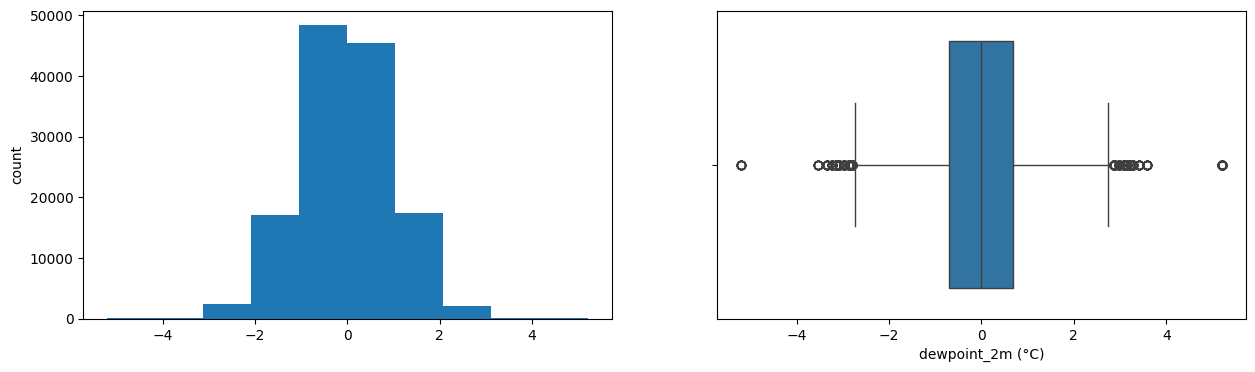

apparent_temperature (°C)
Skew : -0.05


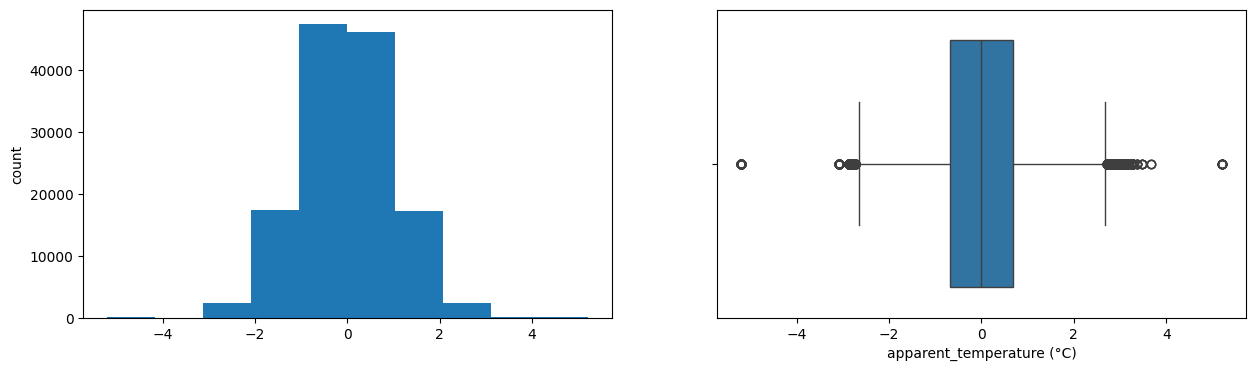

pressure_msl (hPa)
Skew : -0.04


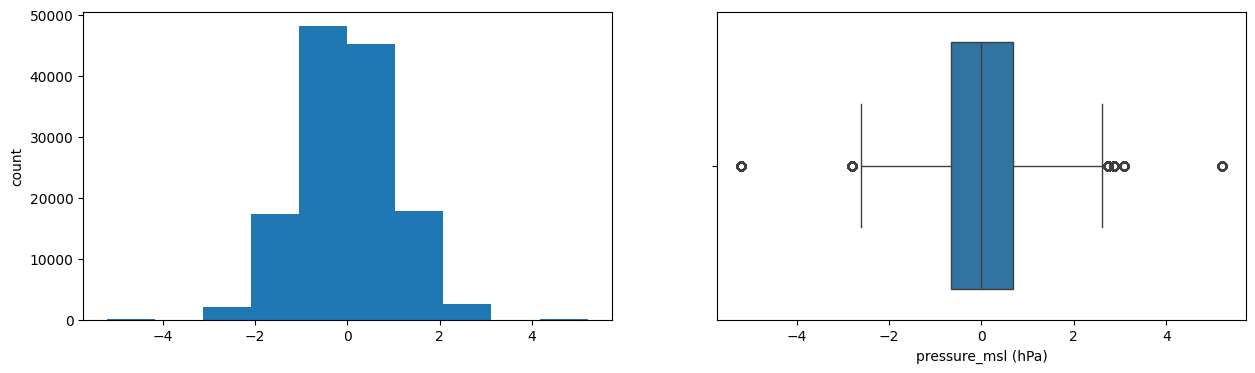

surface_pressure (hPa)
Skew : 0.01


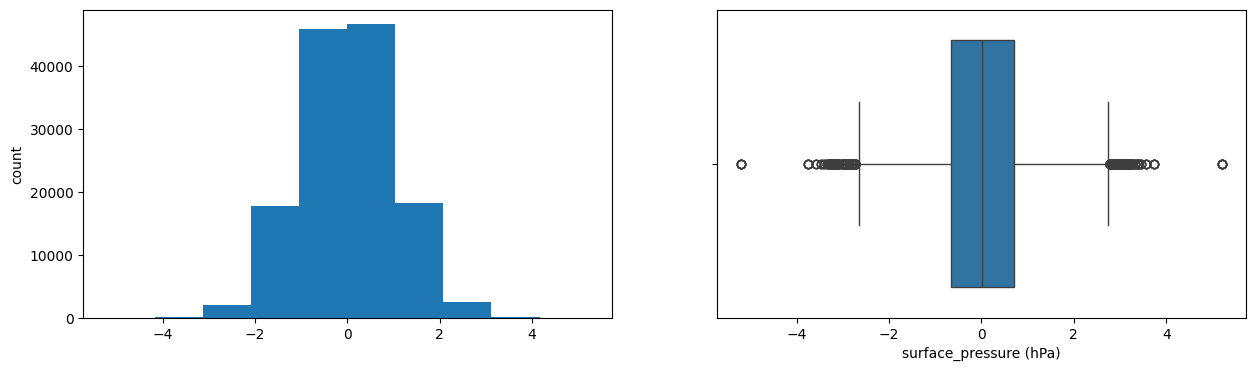

cloudcover (%)
Skew : 1.18


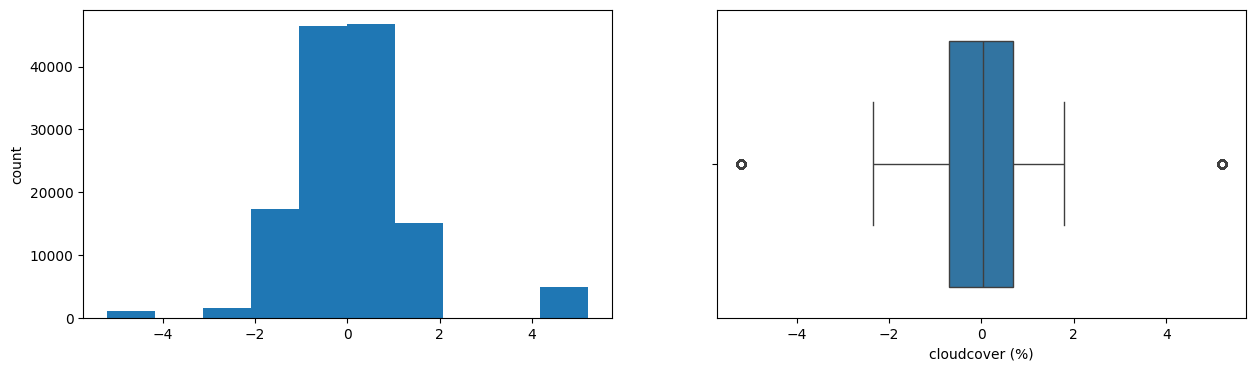

cloudcover_low (%)
Skew : -1.6


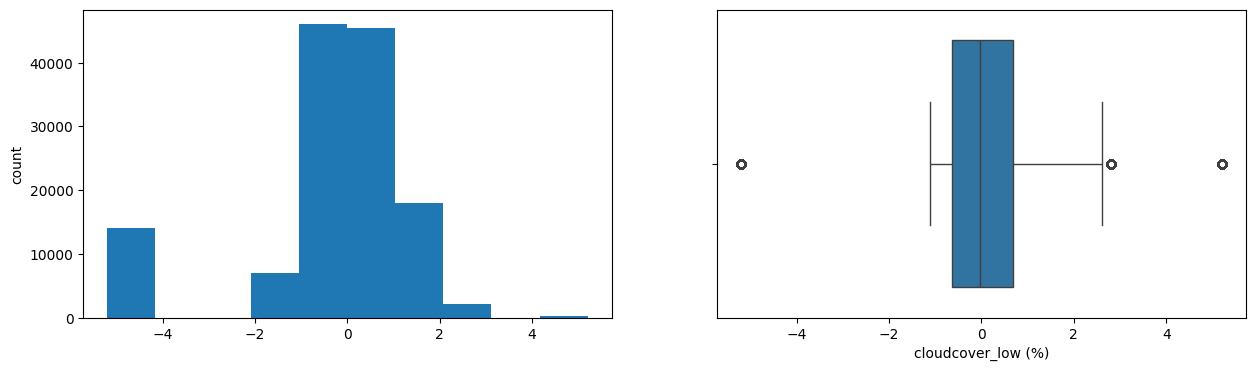

cloudcover_mid (%)
Skew : -1.52


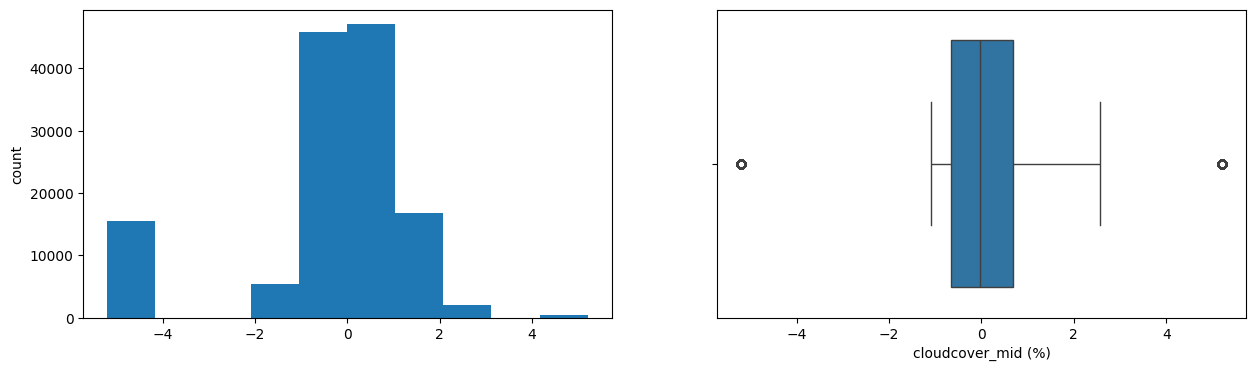

cloudcover_high (%)
Skew : 0.16


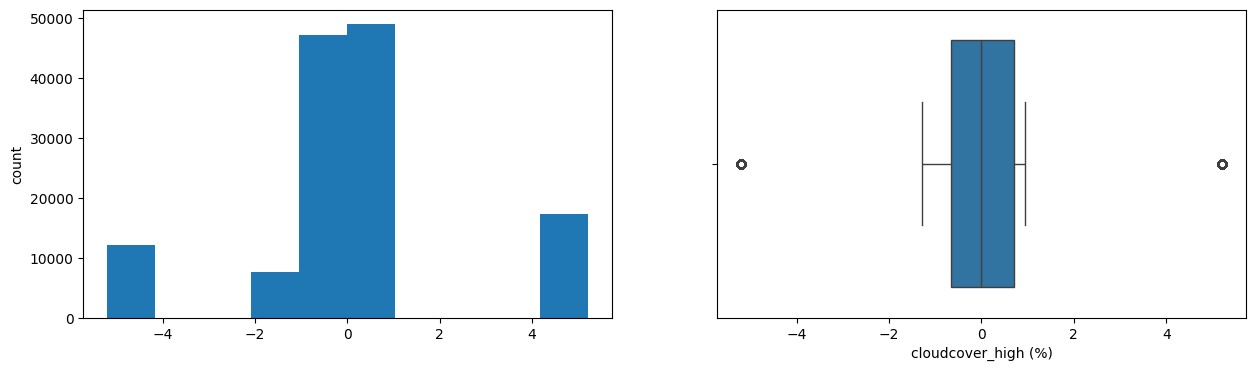

shortwave_radiation (W/m²)
Skew : 0.3


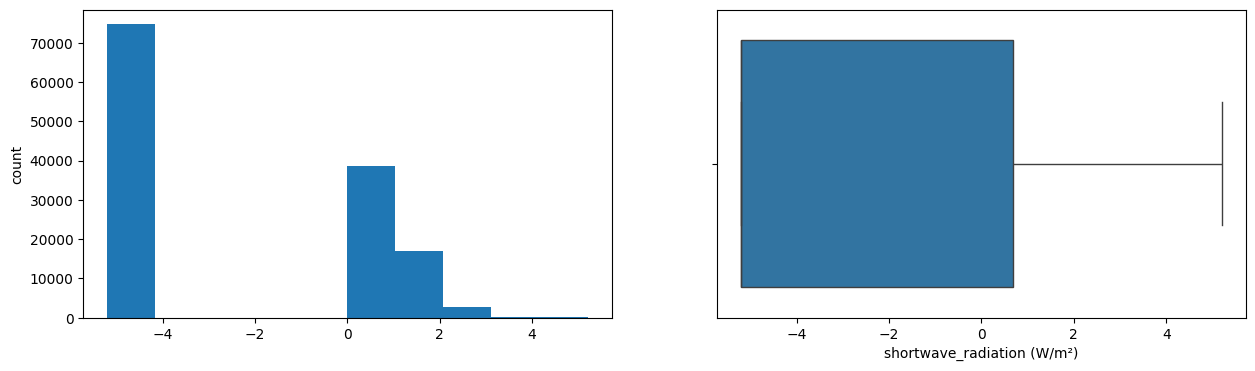

direct_radiation (W/m²)
Skew : 0.39


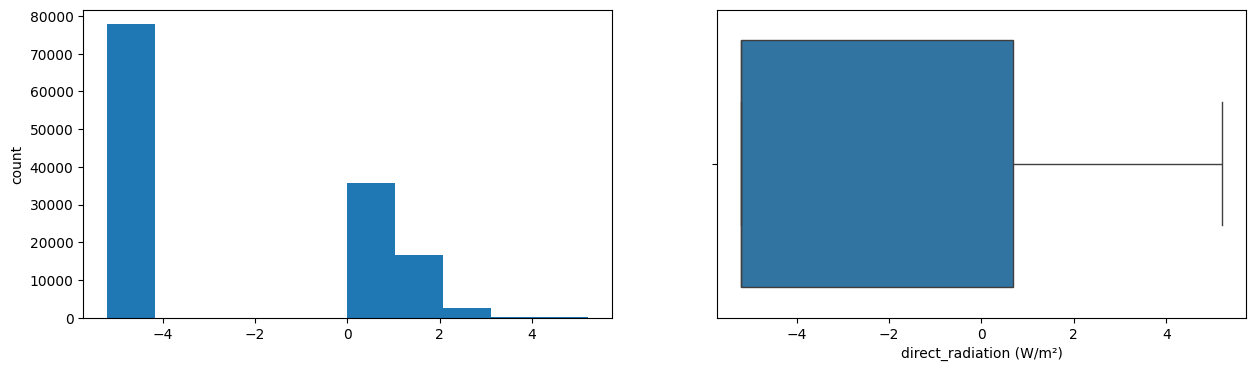

diffuse_radiation (W/m²)
Skew : 0.3


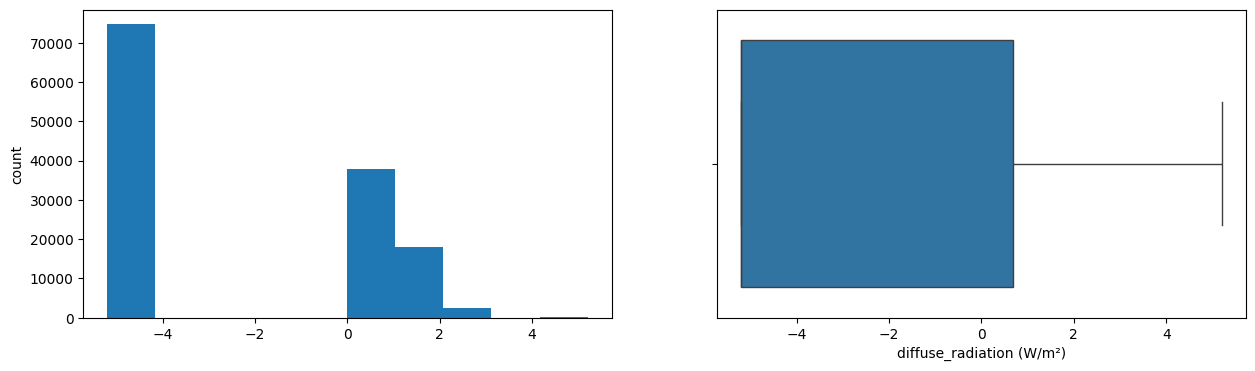

direct_normal_irradiance (W/m²)
Skew : 0.5


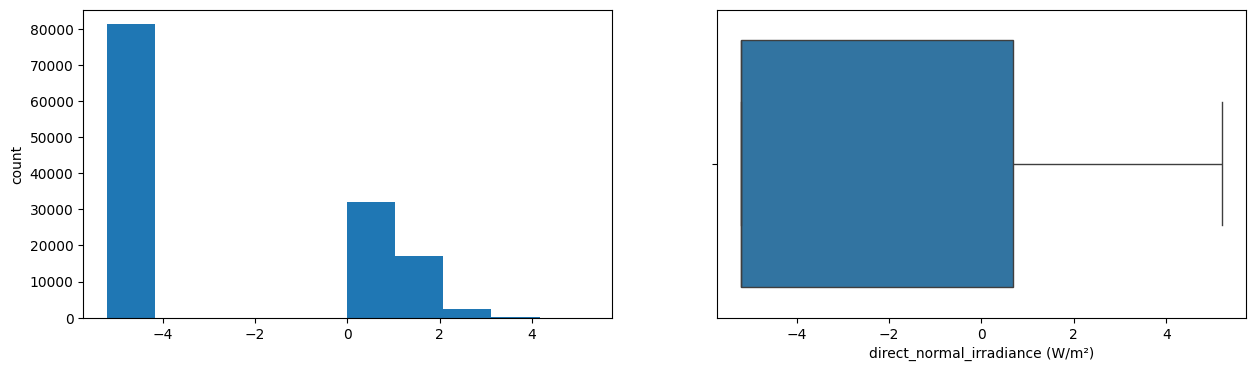

windspeed_10m (km/h)
Skew : -0.23


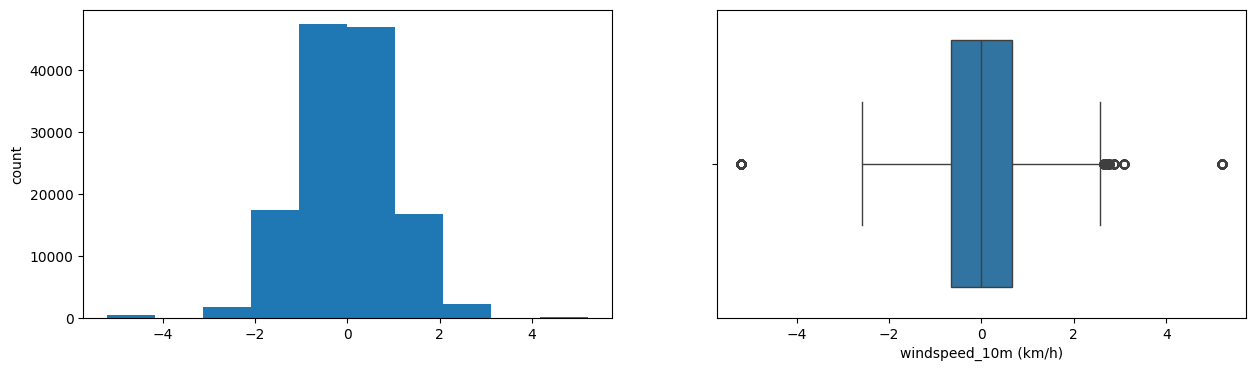

windspeed_100m (km/h)
Skew : -0.04


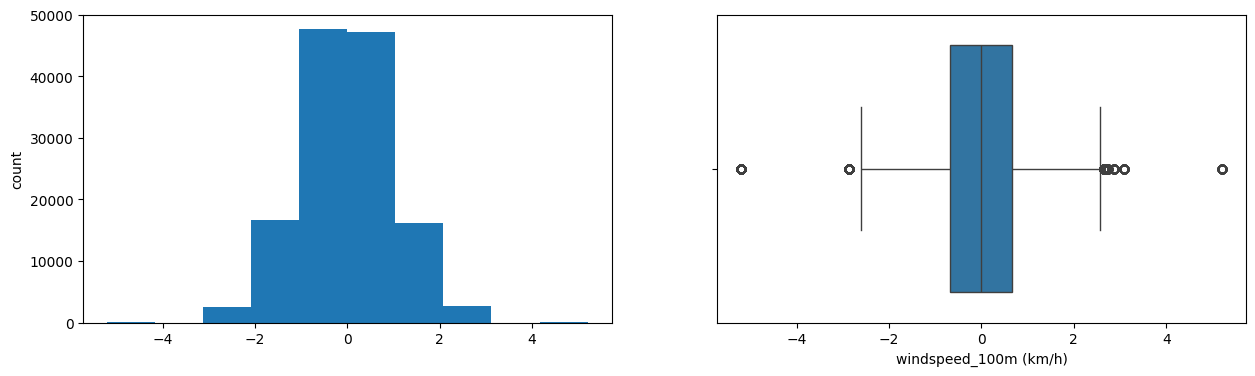

winddirection_10m (°)
Skew : 0.09


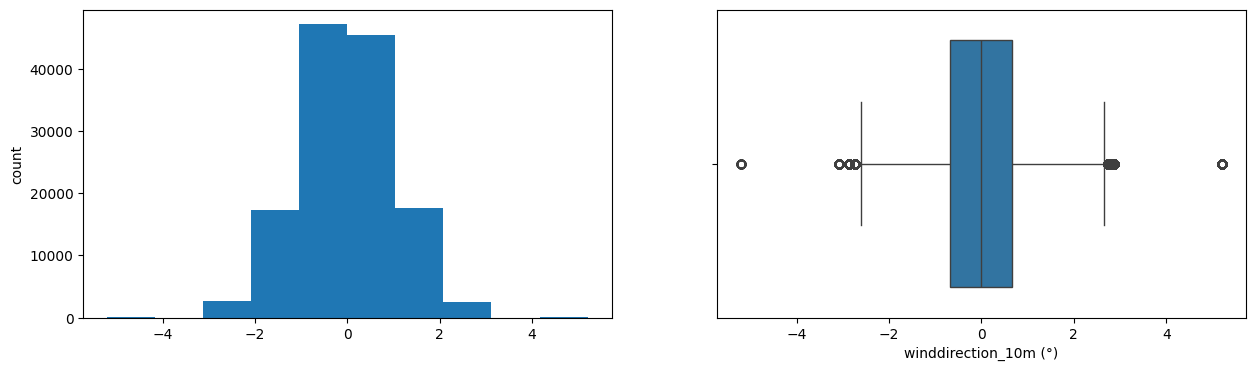

winddirection_100m (°)
Skew : 0.1


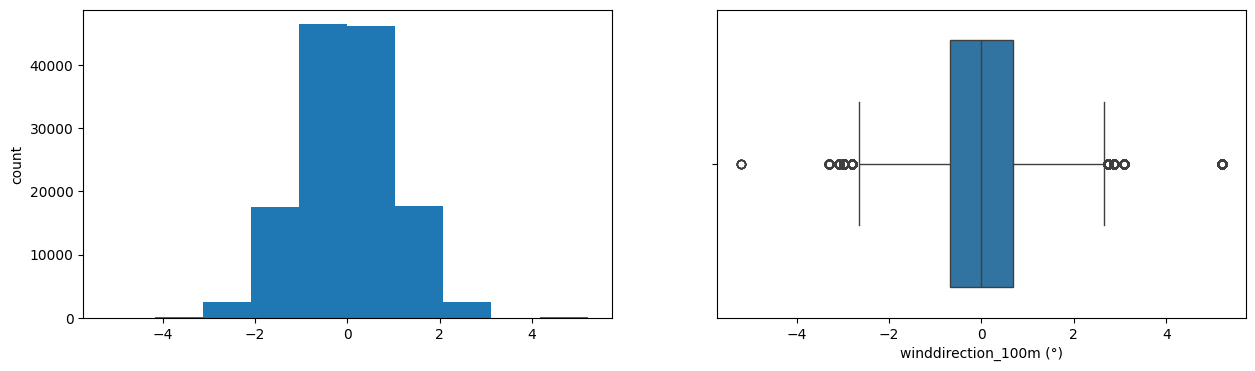

windgusts_10m (km/h)
Skew : 0.1


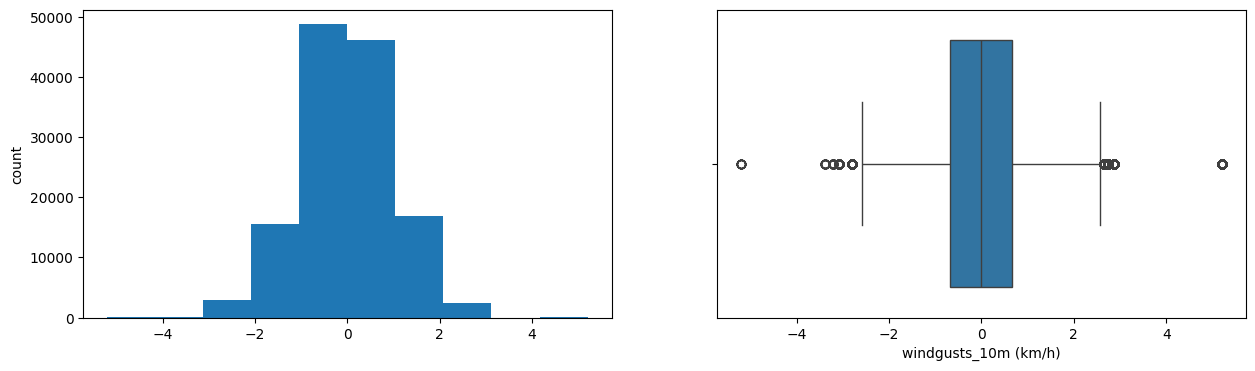

et0_fao_evapotranspiration (mm)
Skew : -0.04


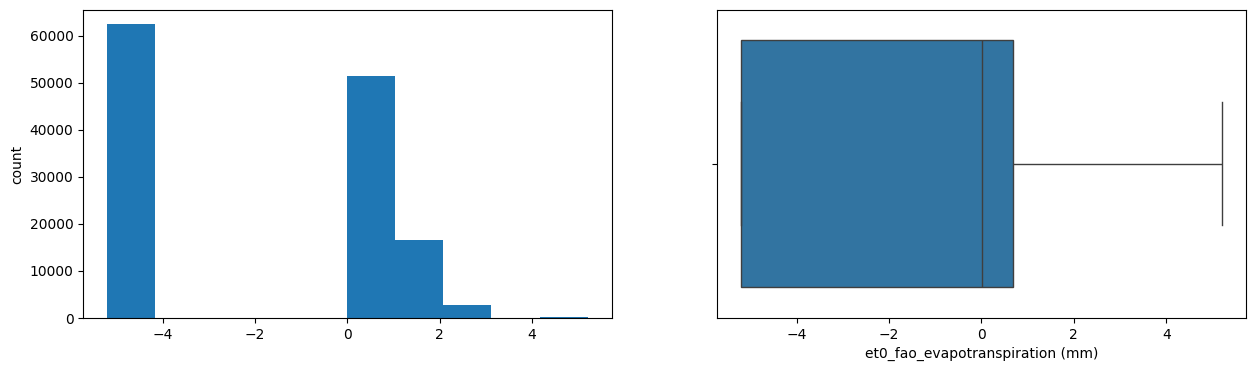

vapor_pressure_deficit (kPa)
Skew : -0.27


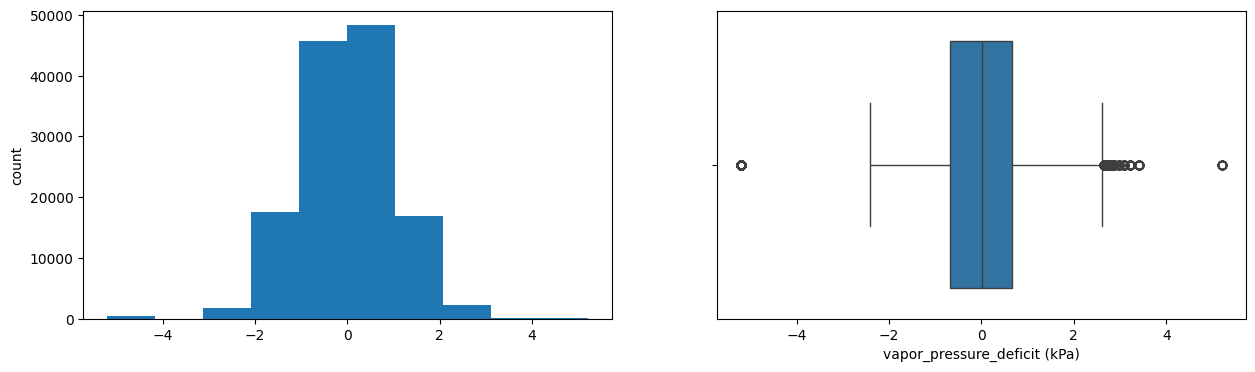

soil_temperature_0_to_7cm (°C)
Skew : 0.05


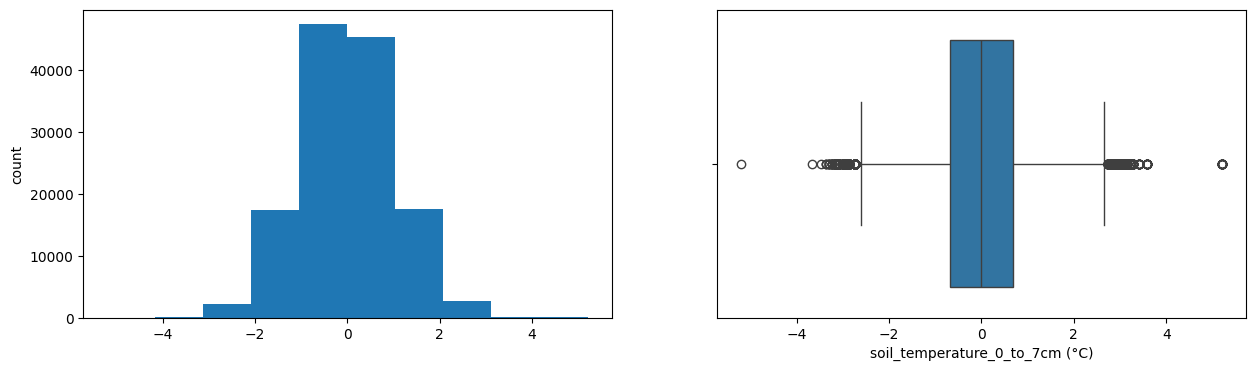

soil_temperature_7_to_28cm (°C)
Skew : 0.07


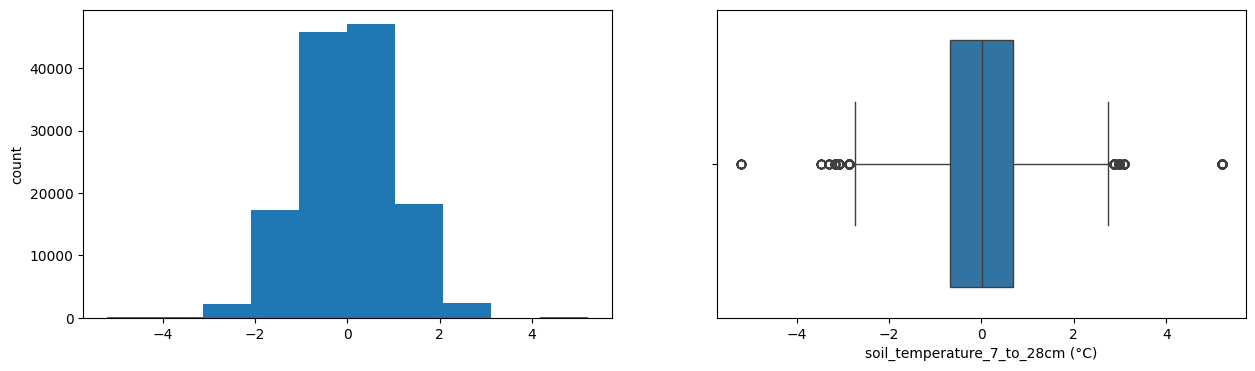

soil_temperature_28_to_100cm (°C)
Skew : 0.03


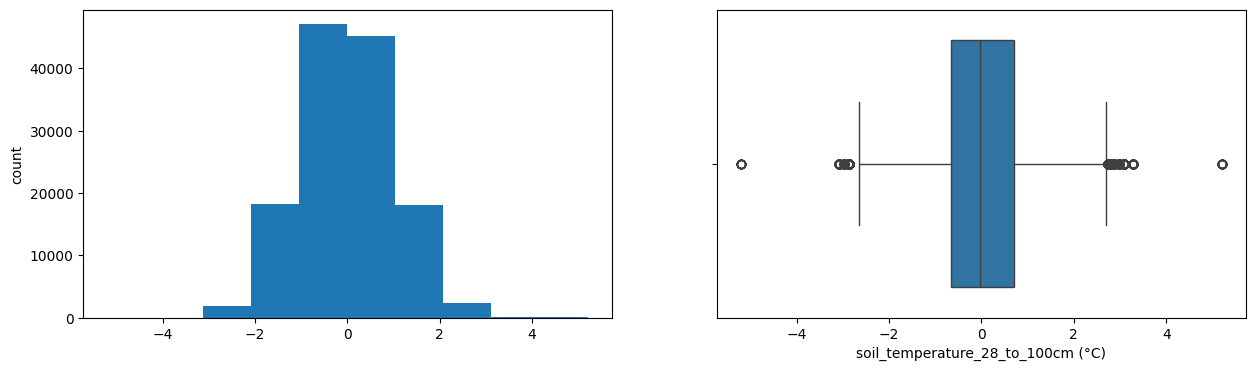

soil_temperature_100_to_255cm (°C)
Skew : 0.22


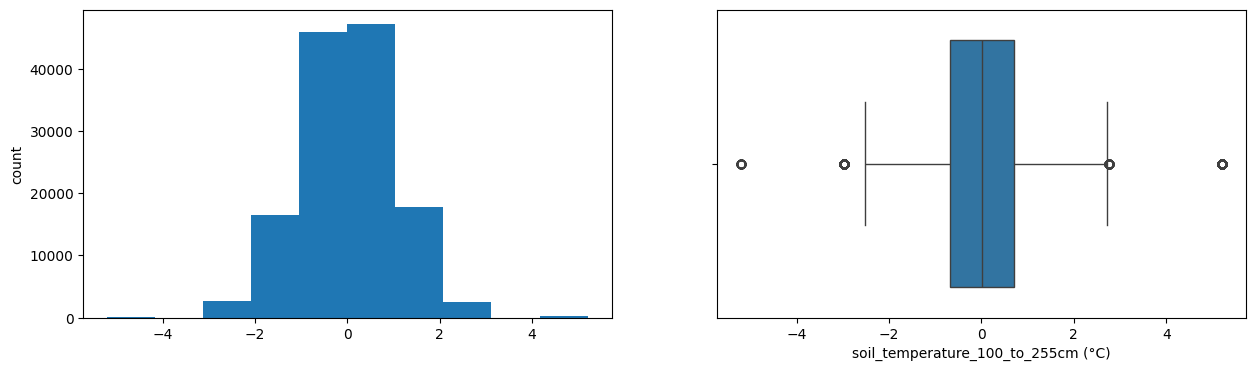

soil_moisture_0_to_7cm (m³/m³)
Skew : 0.1


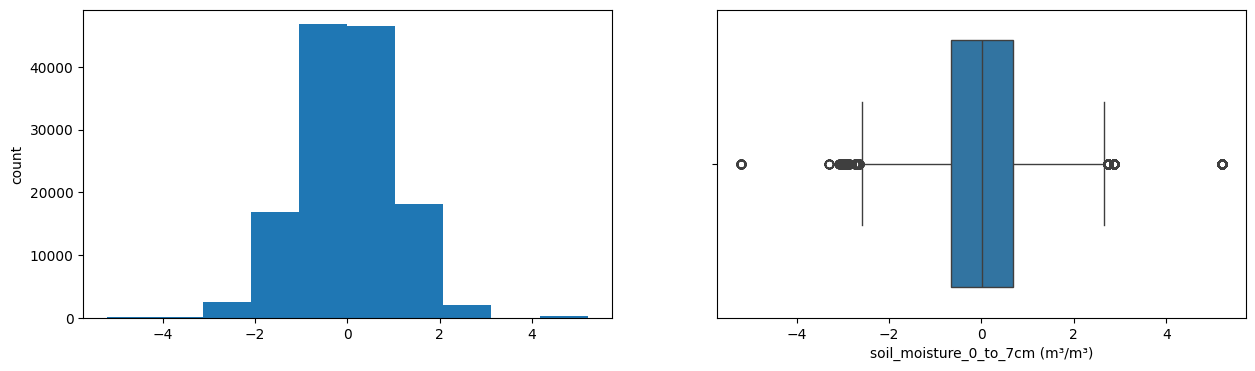

soil_moisture_7_to_28cm (m³/m³)
Skew : -0.01


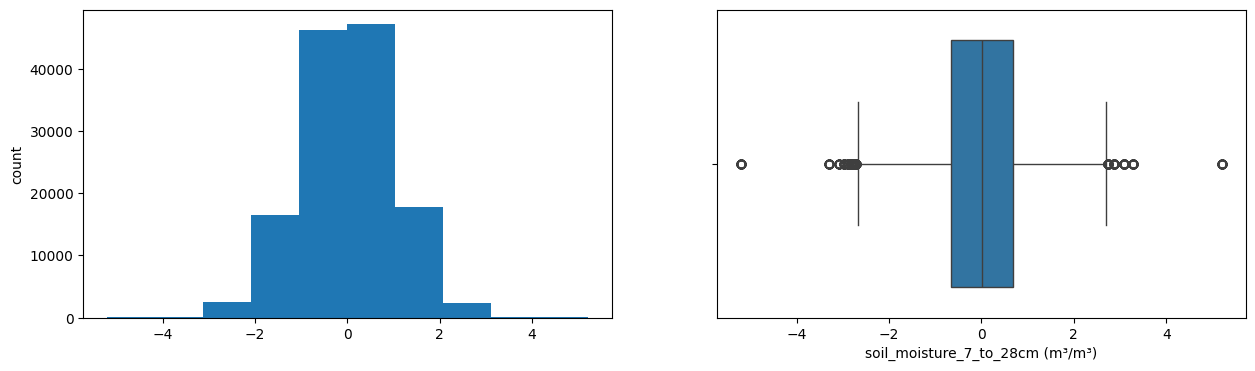

soil_moisture_28_to_100cm (m³/m³)
Skew : -0.01


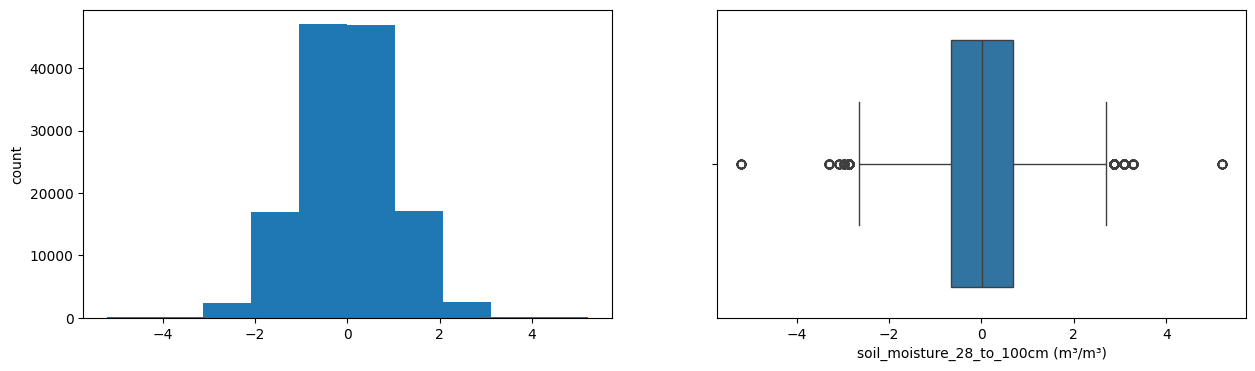

soil_moisture_100_to_255cm (m³/m³)
Skew : -0.29


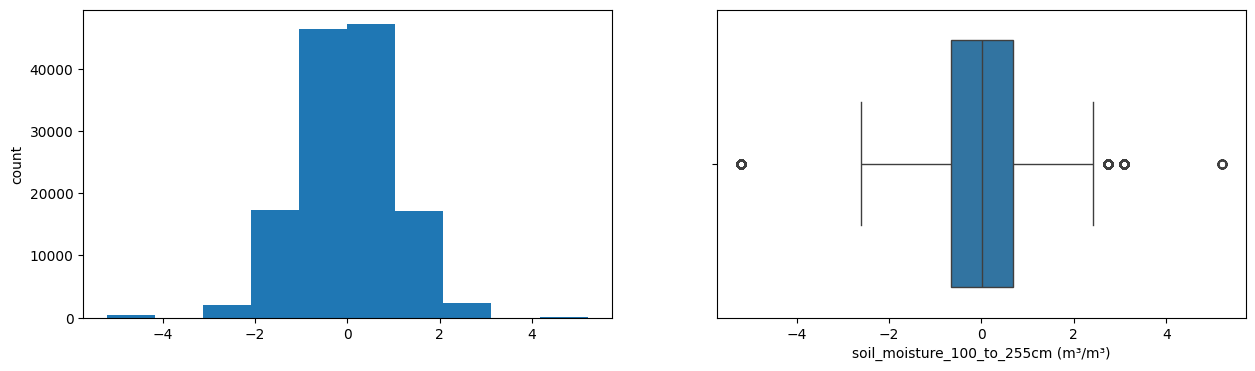

city
Skew : 0.38


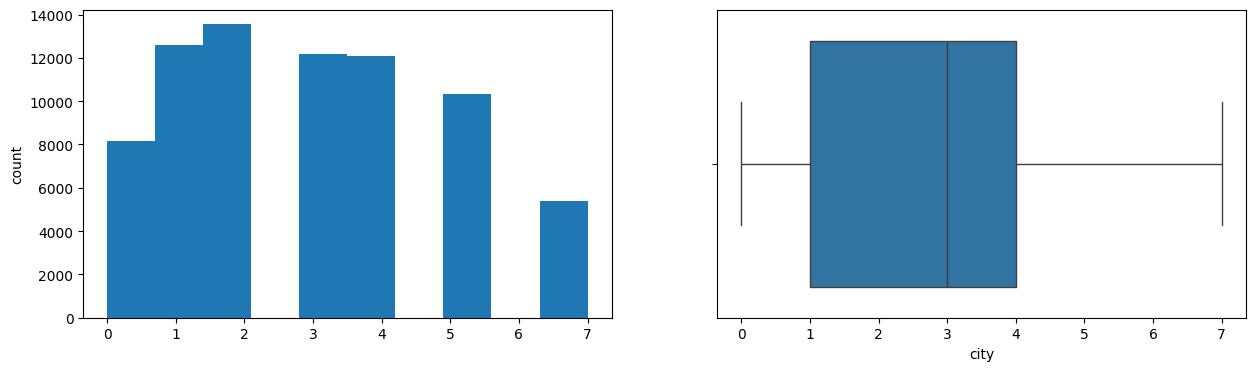

In [812]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_columns = train.select_dtypes(include=["int64", "float64"]).columns
for col in numeric_columns:
    print(col)
    print("Skew :", round(train[col].skew(), 2))
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    train[col].hist(grid=False)
    plt.ylabel("count")
    plt.subplot(1, 2, 2)
    sns.boxplot(x=train[col])
    plt.show()

In [813]:
train = train.select_dtypes(exclude=["object"])
train.dropna(axis=0, inplace=True)

In [814]:
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

X = train.drop("city", axis=1)  # features
y = train["city"].astype("int64")  # target variable

# Print class distribution before SMOTE
print("Original city class distribution:", Counter(y))

# Apply SMOTE
smote = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Print class distribution after SMOTE
print("Class city distribution after SMOTE:", Counter(y_resampled))

# Create a new balanced DataFrame if needed
train = pd.concat(
    [pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name="city")],
    axis=1,
)

Original city class distribution: Counter({2: 13544, 1: 12595, 3: 12171, 4: 12088, 5: 10336, 0: 8145, 7: 5402})
Class city distribution after SMOTE: Counter({7: 12916, 0: 11960, 5: 11144, 4: 10472, 3: 10354, 1: 10109, 2: 9801})


In [815]:
X = train.drop(columns=[TARGET])
y = train[TARGET]

## **Modeling**

In modelling I used an optuna study to tune the hyperparams in order to keep a relatively-stable score range. This "tuned" dataset that we've handled thus far have gotten me from a 184 to a 194-ish MSE on the test set when uploaded to Kaggle. My rationale behind the "why" there's a good bit of stochasticity in the result's MSE is that, as I tuned on RMSE, there might be some dissonance as to how the score is handled (as RMSE puts some weight on outlier predictions as well).

This was a bit better tho, as initially I was only tuning on the top 3 (`max_depth`, `learning_rate`, and `n_estimators`) hyperparams, and doing that gave me a larger range of about 186 to 200-ish, but I thought that there might be some significance to the other hyperparams, so I added those in, and that gave me the current, more stable, range.


In [816]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np


def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0),
    }

    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Create and train the model
    model = XGBRegressor(**params, random_state=42)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False,
    )

    # Make predictions on validation set
    y_pred = model.predict(X_val)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return rmse


# Create a study object and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)  # You can adjust the number of trials

# Print the best parameters and the best score
print("Best parameters:", study.best_params)
print("Best RMSE:", study.best_value)

[I 2024-10-09 01:17:57,968] A new study created in memory with name: no-name-ea9f2f7f-99f4-4dbb-bc23-4c22a1436f3f


[I 2024-10-09 01:18:01,164] Trial 0 finished with value: 0.5951609749475644 and parameters: {'max_depth': 1, 'learning_rate': 0.012265913850290501, 'n_estimators': 140, 'min_child_weight': 5, 'subsample': 0.5356907183678252, 'colsample_bytree': 0.826835419903833, 'gamma': 0.4223568669484317, 'reg_alpha': 0.9800127207570488, 'reg_lambda': 0.8852139309888191}. Best is trial 0 with value: 0.5951609749475644.
[I 2024-10-09 01:18:07,009] Trial 1 finished with value: 0.23903095908085117 and parameters: {'max_depth': 8, 'learning_rate': 0.08906880751731903, 'n_estimators': 152, 'min_child_weight': 2, 'subsample': 0.7426173527596365, 'colsample_bytree': 0.8509745894184217, 'gamma': 0.45503128643305435, 'reg_alpha': 0.5785371507133655, 'reg_lambda': 0.21687176257672128}. Best is trial 1 with value: 0.23903095908085117.
[I 2024-10-09 01:18:16,265] Trial 2 finished with value: 0.24515381097900274 and parameters: {'max_depth': 8, 'learning_rate': 0.07862289026069032, 'n_estimators': 287, 'min_chil

Best parameters: {'max_depth': 10, 'learning_rate': 0.063524417286578, 'n_estimators': 275, 'min_child_weight': 8, 'subsample': 0.7198268226128695, 'colsample_bytree': 0.9754407570255066, 'gamma': 0.04780010479797564, 'reg_alpha': 0.012604847641886352, 'reg_lambda': 0.13521174717413126}
Best RMSE: 0.2119274667731019


In [817]:
best_params = study.best_params
best_model = XGBRegressor(**best_params, random_state=42)
best_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9754407570255066, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.04780010479797564,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.063524417286578,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=275, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [818]:
test["city"] = le.fit_transform(test["city"]).astype(np.int64)
test_df = test
# test_df["time"] = pd.to_datetime(test_df["time"]).dt.hour
test_df = test_df.select_dtypes(exclude=["object"])
test_df = test.drop(["id", "snowfall (cm)", "time"], axis=1)

In [819]:
# Modeling using
"""
Change the code just if you need to
"""

rfr = best_model
predict = rfr.predict(test_df)
submission[TARGET] = predict

submission.to_csv(SUBMISSION_FILE, index=False)

In [820]:
SUBMISSION_FILE

'submission\\submission_9-10-2024-1-15.csv'